### Import dataset


In [1]:
library(tidyverse)

setwd("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/_m/")
data <- read.csv("features_data.csv")
setwd("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/parameters-analysis/")


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ───────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.4  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ──────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Exploration

In this **data exploration** section we want to see the "face" of our data and parameters through **data visualization** (*box plots* and *density plots*) and a **statistic description** (*mean*, *median*, *standard deviantion*, *variance*, *max*, *min*, etc).

### Essential functions

Here below was built a simple function `get.description()` to get a **statistic description** of each parameter. This function is used in the follow function `mount.description()` to **mount a table** for a neatier presentation.

In [2]:
# get a statistic description of the data
get.description <- function(data){ 
    data.description <- as.matrix(summary(data))# statistic summary
    data.description <- t(data.description)     # horizontalize
    data.description <- cbind(data.description, Var = var(data),
                              Sd = sd(data), N = length(data))
    return(as.data.frame(data.description))
}

# mount description table/data-frame
mount.description <- function(data, variable, region = FALSE){
if(region == FALSE){
  groups <- c("CS","AS","AL")
  for(i in groups){
    temp.data <- data %>% 
        filter(Grupo == i) %>% 
        select(variable)
    if(i == "CS"){
        data.description <- cbind(Grupo = i, get.description(temp.data[,1]))
    }
    else{
        temp.description <- cbind(Grupo = i, get.description(temp.data[,1]))
        data.description <- rbind(data.description, temp.description)
    }
  }
  return(data.description)
}
else{
  groups <- c("CS","AS","AL")
  regions <- c("CA1","CA3","GD")
  for(g in groups){
      for(r in regions){
        temp.data <- data %>% 
        filter(Grupo == g & Region == r) %>% 
        select(variable)
        if(g == "CS" & r == "CA1"){
            data.description <- cbind(Grupo = g, Região = r,
                                      get.description(temp.data[,1]))
        }
        else{
            temp.description <- cbind(Grupo = g, Região = r,
                                  get.description(temp.data[,1]))
            data.description <- rbind(data.description, temp.description)
        }
    }
  }
  return(data.description)
  }
}

Here I have two functions `custom.density.plot()` and `custom.box.plot()` with a reproducible *ggplot* setup for a *desity plot* and a *box plot* that will be used for each parameter **data visualization**.

In [3]:
# density plot
custom.density.plot <- function(data,variable, region = FALSE){
  data.id  <- data[,1:4] 
  data.var <- data[variable]
  data     <- cbind(data.id,data.var)
  colnames(data) <- c("Animal","Corte","Grupo","Region","x")
  
  if(region == FALSE){
    p <- ggplot(data,aes(x, fill = Grupo)) +
         geom_density(alpha = 0.7) + xlab(variable) +
         ggtitle(label = "Density plot") + labs(fill = "Group") +
         theme(legend.direction ="horizontal", legend.position = "top",
               plot.title = element_text(hjust = 0.5)) +
         scale_fill_manual(values = c("#d0d0d0","#008080","#f07f13"))
    return(p)
  }
  else{
    p <- ggplot(data,aes(x, fill = Grupo)) +
         geom_density(alpha = 0.7) + xlab(variable) +
         ggtitle(label = "Density plot") + labs(fill = "Group") +
         theme(legend.direction ="horizontal", legend.position = "top",
               plot.title = element_text(hjust = 0.5)) +
         facet_grid(~Region) +
         scale_fill_manual(values = c("#d0d0d0","#008080","#f07f13"))
    return(p)
  }
}

# box plot
custom.box.plot <- function(data,variable, region = FALSE){
  data.id  <- data[,1:4] 
  data.var <- data[variable]
  data     <- cbind(data.id,data.var)
  colnames(data) <- c("Animal","Corte","Grupo","Region","x")
  
  if(region == FALSE){
    p <- ggplot(data,aes(x = Grupo, y = x, fill = Grupo)) +
         geom_boxplot() + ylab(variable) + xlab(NULL) +
         ggtitle(label = "Box plot") + labs(fill = "Group") +
         theme(legend.direction ="horizontal", legend.position = "top",
               plot.title = element_text(hjust = 0.5)) +
         scale_fill_manual(values = c("#d0d0d0","#008080","#f07f13"))
    return(p)
  }
  else{
    p <- ggplot(data,aes(x = Grupo, y = x, fill = Grupo)) +
         geom_boxplot() + ylab(variable) + xlab(NULL) +
         ggtitle(label = "Box plot") + labs(fill = "Group") +
         theme(legend.direction ="horizontal", legend.position = "top",
               plot.title = element_text(hjust = 0.5)) +
         facet_grid(~Region) +
         scale_fill_manual(values = c("#d0d0d0","#008080","#f07f13"))
    return(p)
  }
}

And finally the function `multiplot()`, from cookbook-r, was used to present both *density plot* and *box plot* side by side.

In [4]:
# multiplot from cookbook-r
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)
  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

### Foreground Pixels/Hull Area
A description of the parameter.

#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   | 0.289 |  0.510  | 0.632  | 0.652 |  0.776  | 1.065 | 0.032 | 0.180 | 720 |
|  AS   | 0.273 |  0.554  | 0.664  | 0.693 |  0.836  | 1.074 | 0.032 | 0.180 | 720 |
|  AL   | 0.293 |  0.549  | 0.670  | 0.690 |  0.817  | 1.092 | 0.030 | 0.173 | 720 |

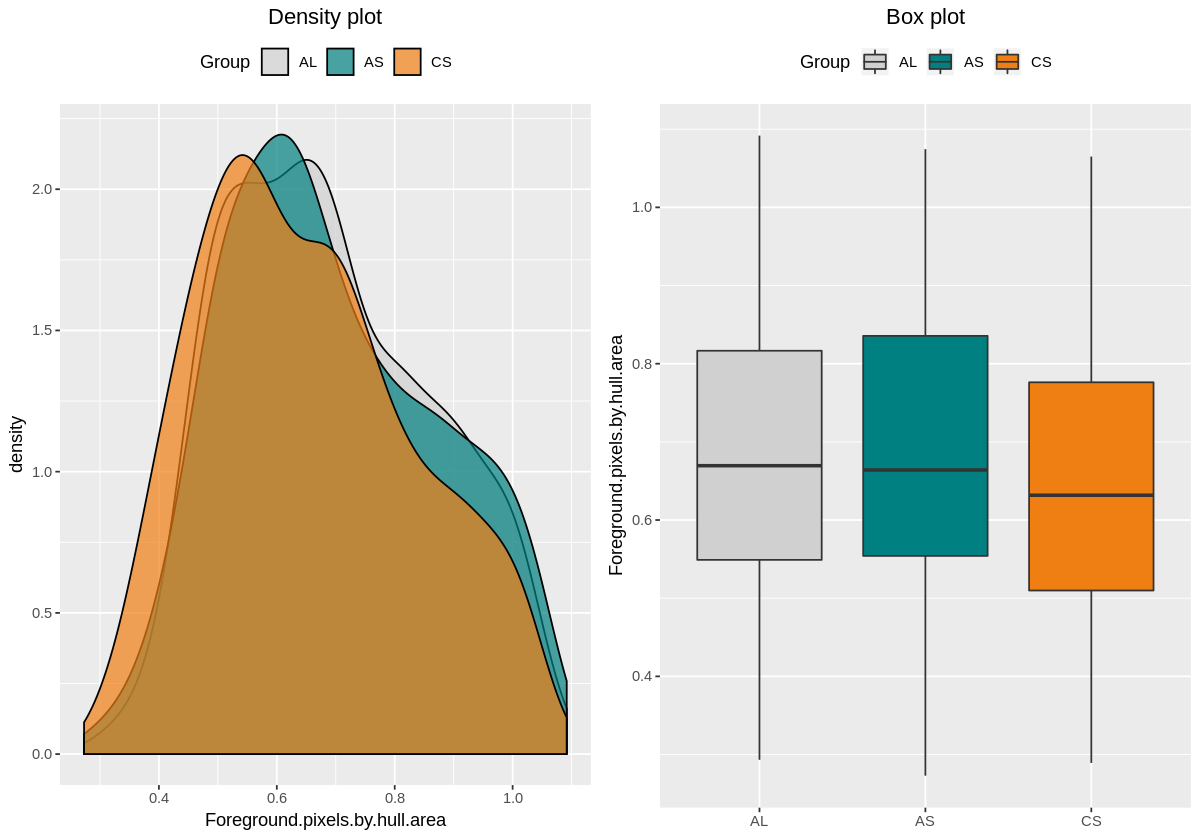

In [43]:
data.description <- mount.description(data, "Foreground.pixels.by.hull.area") 

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))


p1 <- custom.density.plot(data, "Foreground.pixels.by.hull.area")
p2 <- custom.box.plot(data, "Foreground.pixels.by.hull.area")

multiplot(p1,p2,cols = 2)
options(repr.plot.width = 5,repr.plot.width = 10)

#### Regions



| Grupo | Região | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:------:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   |  CA1   | 0.289 |  0.492  | 0.600  | 0.629 |  0.740  | 1.065 | 0.032 | 0.179 | 240 |
|  CS   |  CA3   | 0.307 |  0.504  | 0.638  | 0.641 |  0.767  | 1.038 | 0.031 | 0.175 | 240 |
|  CS   |   GD   | 0.365 |  0.540  | 0.664  | 0.686 |  0.829  | 1.046 | 0.033 | 0.182 | 240 |
|  AS   |  CA1   | 0.273 |  0.541  | 0.662  | 0.683 |  0.799  | 1.074 | 0.032 | 0.180 | 240 |
|  AS   |  CA3   | 0.308 |  0.535  | 0.645  | 0.679 |  0.832  | 1.072 | 0.032 | 0.179 | 240 |
|  AS   |   GD   | 0.361 |  0.578  | 0.686  | 0.717 |  0.865  | 1.061 | 0.032 | 0.179 | 240 |
|  AL   |  CA1   | 0.328 |  0.520  | 0.613  | 0.645 |  0.729  | 1.049 | 0.025 | 0.158 | 240 |
|  AL   |  CA3   | 0.293 |  0.569  | 0.723  | 0.718 |  0.865  | 1.092 | 0.033 | 0.181 | 240 |
|  AL   |   GD   | 0.407 |  0.580  | 0.677  | 0.707 |  0.8

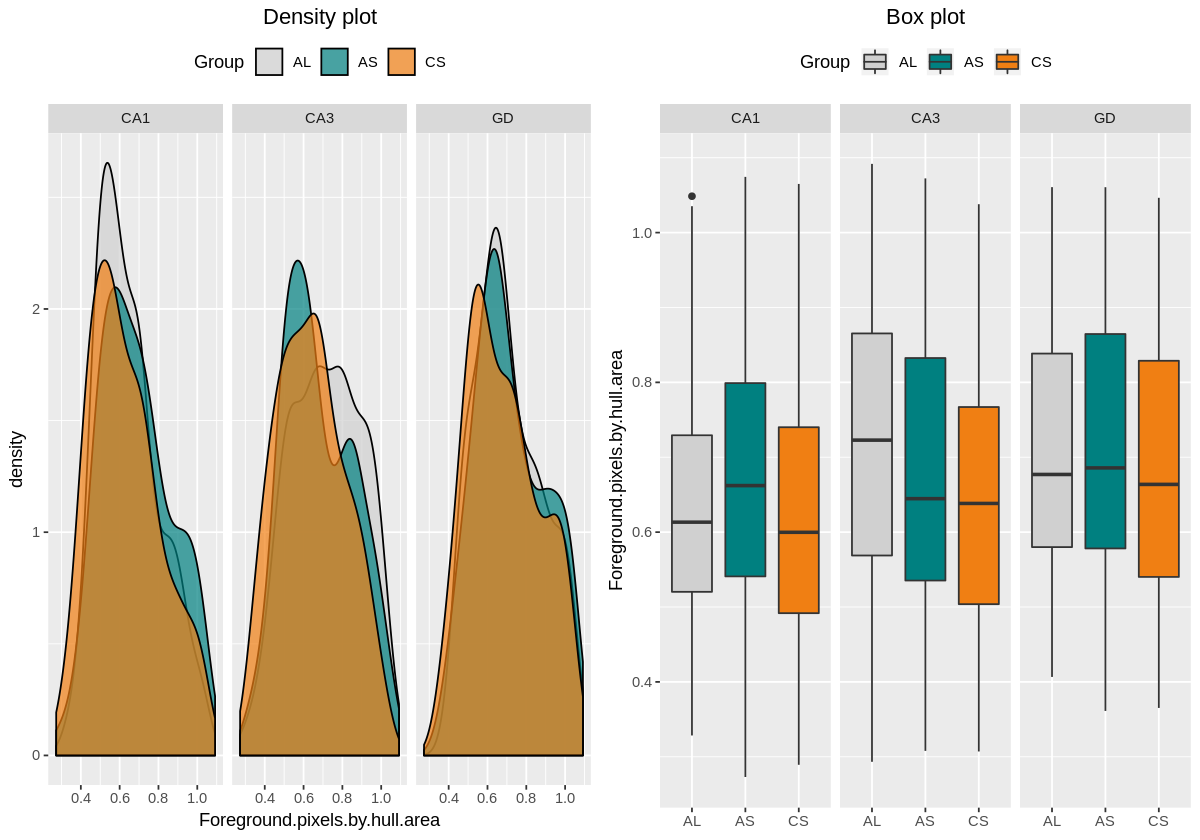

In [6]:
data.description <- mount.description(data, "Foreground.pixels.by.hull.area", 
                                      region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Foreground.pixels.by.hull.area",region = TRUE)
p2 <- custom.box.plot(data,"Foreground.pixels.by.hull.area",region = TRUE)

multiplot(p1,p2,cols = 2)

### Hull Area 
#### Hippocampus



| Grupo | Min. | 1st Qu. | Median |   Mean   | 3rd Qu. | Max. |    Var    |    Sd    |  N  |
|:-----:|:----:|:-------:|:------:|:--------:|:-------:|:----:|:---------:|:--------:|:---:|
|  CS   | 163  | 907.00  | 1603.0 | 2012.732 | 2708.50 | 9674 | 2154254.9 | 1467.738 | 720 |
|  AS   | 169  | 816.75  | 1272.5 | 1611.782 | 2120.00 | 6527 | 1205387.5 | 1097.901 | 720 |
|  AL   | 207  | 790.00  | 1223.0 | 1429.769 | 1840.25 | 4755 | 729922.4  | 854.355  | 720 |

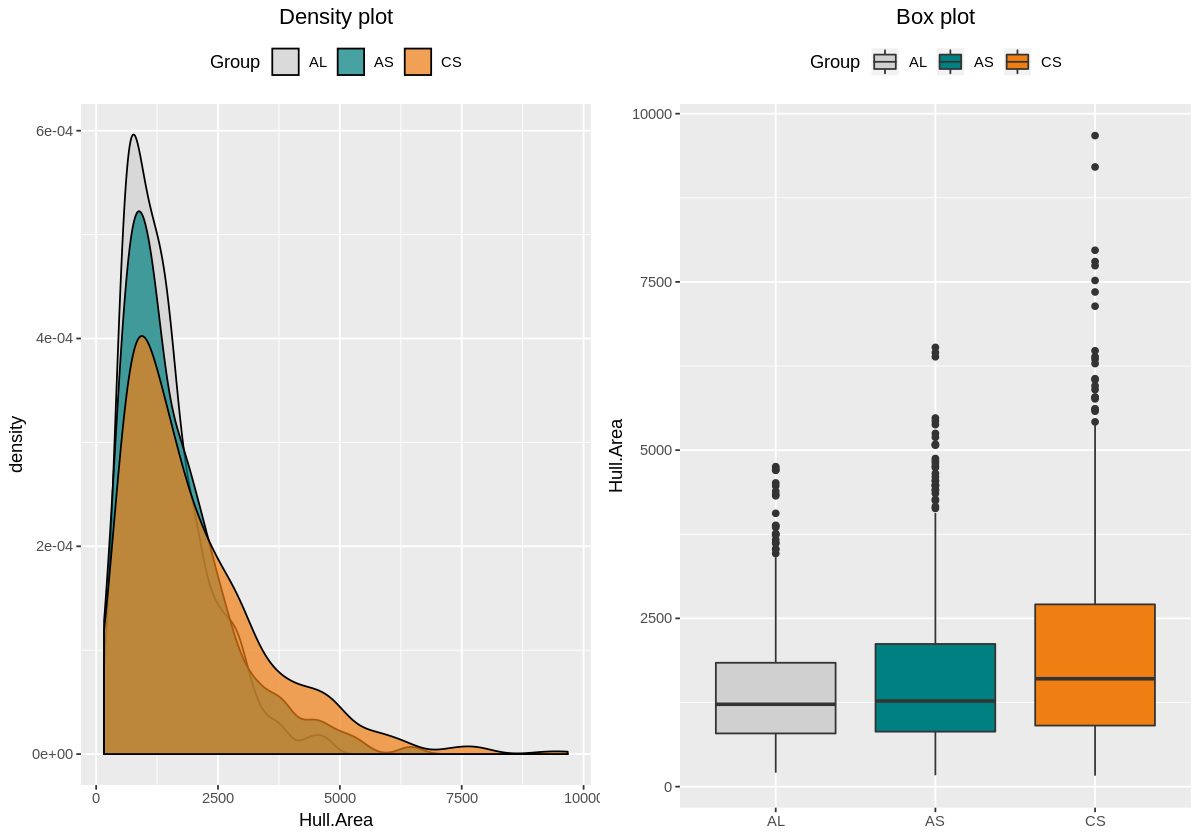

In [7]:
data.description <- mount.description(data, "Hull.Area")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Hull.Area")
p2 <- custom.box.plot(data, "Hull.Area")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median |   Mean   | 3rd Qu. | Max. |    Var    |    Sd    |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:--------:|:-------:|:----:|:---------:|:--------:|:---:|
|  CS   |  CA1   | 163  | 939.00  | 1690.0 | 2124.492 | 2755.75 | 9674 | 2535685.5 | 1592.384 | 240 |
|  CS   |  CA3   | 231  | 981.75  | 1690.5 | 2115.779 | 2905.25 | 7970 | 2167027.1 | 1472.083 | 240 |
|  CS   |   GD   | 262  | 816.50  | 1439.5 | 1797.925 | 2419.25 | 7521 | 1708538.7 | 1307.111 | 240 |
|  AS   |  CA1   | 215  | 846.00  | 1347.0 | 1708.429 | 2274.25 | 6527 | 1369474.2 | 1170.245 | 240 |
|  AS   |  CA3   | 221  | 826.75  | 1300.5 | 1653.388 | 2124.25 | 6451 | 1269551.3 | 1126.744 | 240 |
|  AS   |   GD   | 169  | 778.50  | 1180.0 | 1473.529 | 1993.75 | 6387 | 956912.1  | 978.219  | 240 |
|  AL   |  CA1   | 286  | 924.75  | 1405.5 | 1620.267 | 2057.00 | 4755 | 867082.5  | 931.173  | 240 |
|  AL   |  CA3   | 207  | 734.50  | 1115.5 | 1356.083 | 1685.00 | 4513 | 739102.

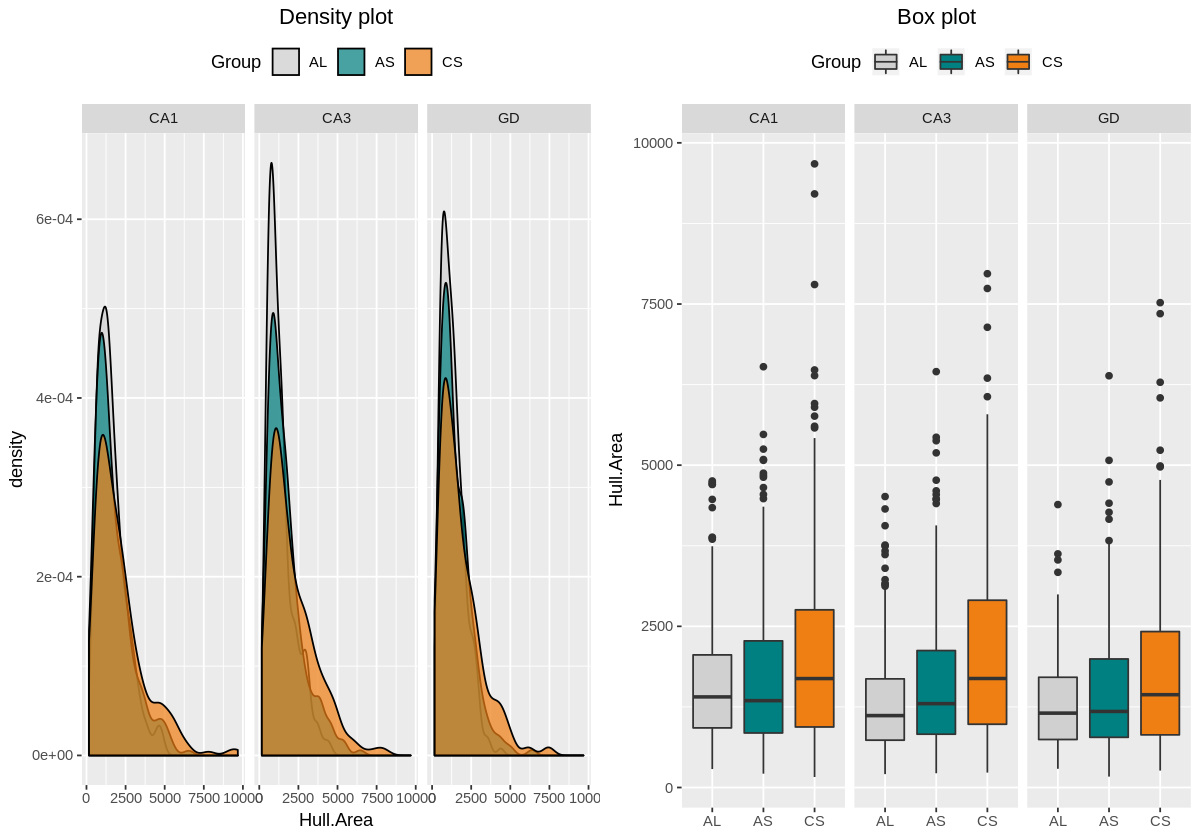

In [8]:
data.description <- mount.description(data, "Hull.Area", region = TRUE) 

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Hull.Area", region = TRUE)
p2 <- custom.box.plot(data, "Hull.Area", region = TRUE)

multiplot(p1,p2,cols = 2)

### Diameter of Bounding Circle
#### Hippocampus



| Grupo |  Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.   |   Var   |   Sd   |  N  |
|:-----:|:------:|:-------:|:------:|:------:|:-------:|:-------:|:-------:|:------:|:---:|
|  CS   | 18.824 | 48.023  | 63.223 | 68.395 | 86.194  | 177.023 | 691.631 | 26.299 | 720 |
|  AS   | 18.713 | 44.360  | 59.259 | 61.466 | 74.464  | 197.274 | 524.848 | 22.910 | 720 |
|  AL   | 19.692 | 43.926  | 56.734 | 59.031 | 71.873  | 158.981 | 404.383 | 20.109 | 720 |

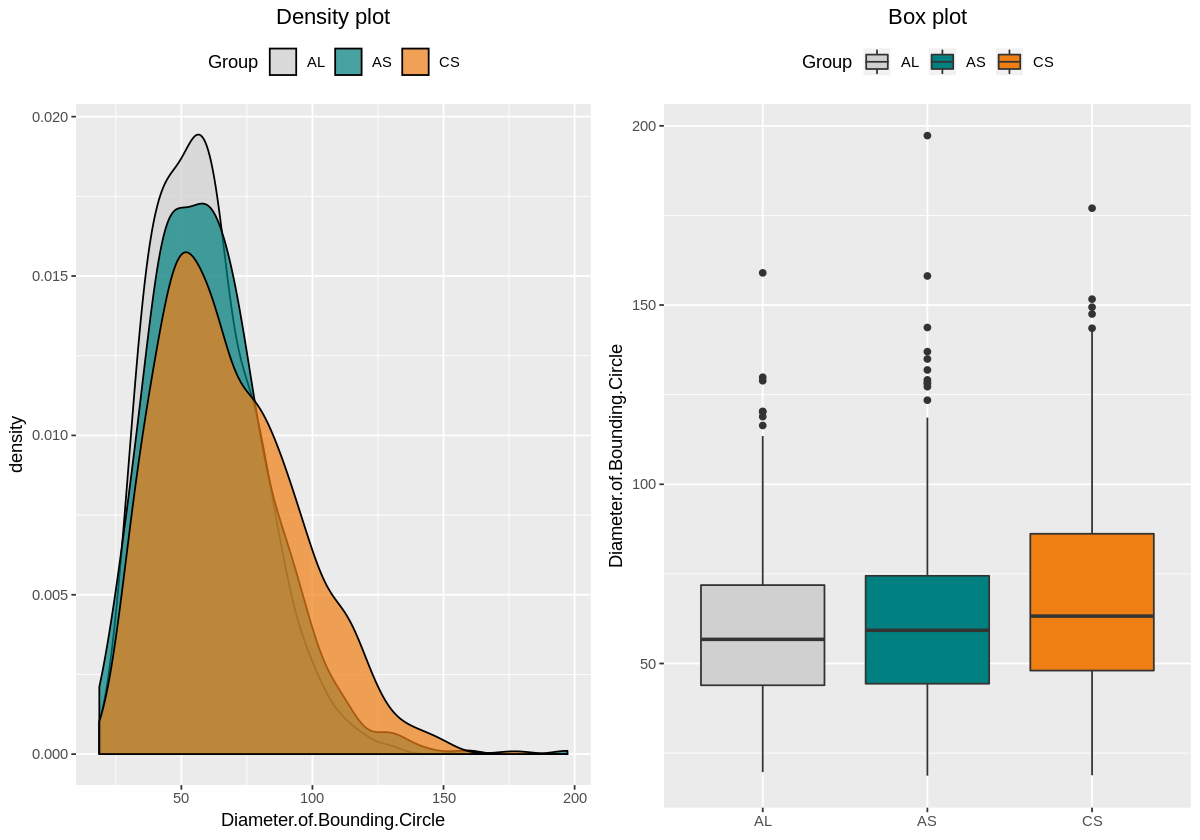

In [9]:
data.description <- mount.description(data, "Diameter.of.Bounding.Circle")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Diameter.of.Bounding.Circle")
p2 <- custom.box.plot(data, "Diameter.of.Bounding.Circle")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região |  Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.   |   Var   |   Sd   |  N  |
|:-----:|:------:|:------:|:-------:|:------:|:------:|:-------:|:-------:|:-------:|:------:|:---:|
|  CS   |  CA1   | 18.824 | 50.975  | 67.255 | 71.318 | 88.687  | 151.648 | 734.885 | 27.109 | 240 |
|  CS   |  CA3   | 23.487 | 48.353  | 65.327 | 69.918 | 87.647  | 147.492 | 694.413 | 26.352 | 240 |
|  CS   |   GD   | 25.010 | 44.738  | 61.701 | 63.950 | 81.491  | 177.023 | 620.634 | 24.913 | 240 |
|  AS   |  CA1   | 19.698 | 46.552  | 60.150 | 63.543 | 74.464  | 197.274 | 607.861 | 24.655 | 240 |
|  AS   |  CA3   | 18.713 | 44.978  | 59.301 | 62.123 | 75.712  | 143.736 | 486.137 | 22.049 | 240 |
|  AS   |   GD   | 19.105 | 41.473  | 58.146 | 58.732 | 73.838  | 158.114 | 472.669 | 21.741 | 240 |
|  AL   |  CA1   | 25.495 | 49.997  | 61.879 | 63.757 | 76.568  | 129.865 | 397.302 | 19.932 | 240 |
|  AL   |  CA3   | 19.692 | 40.686  | 55.236 | 57.665 | 68.312  | 158.981 | 473.825 | 21.

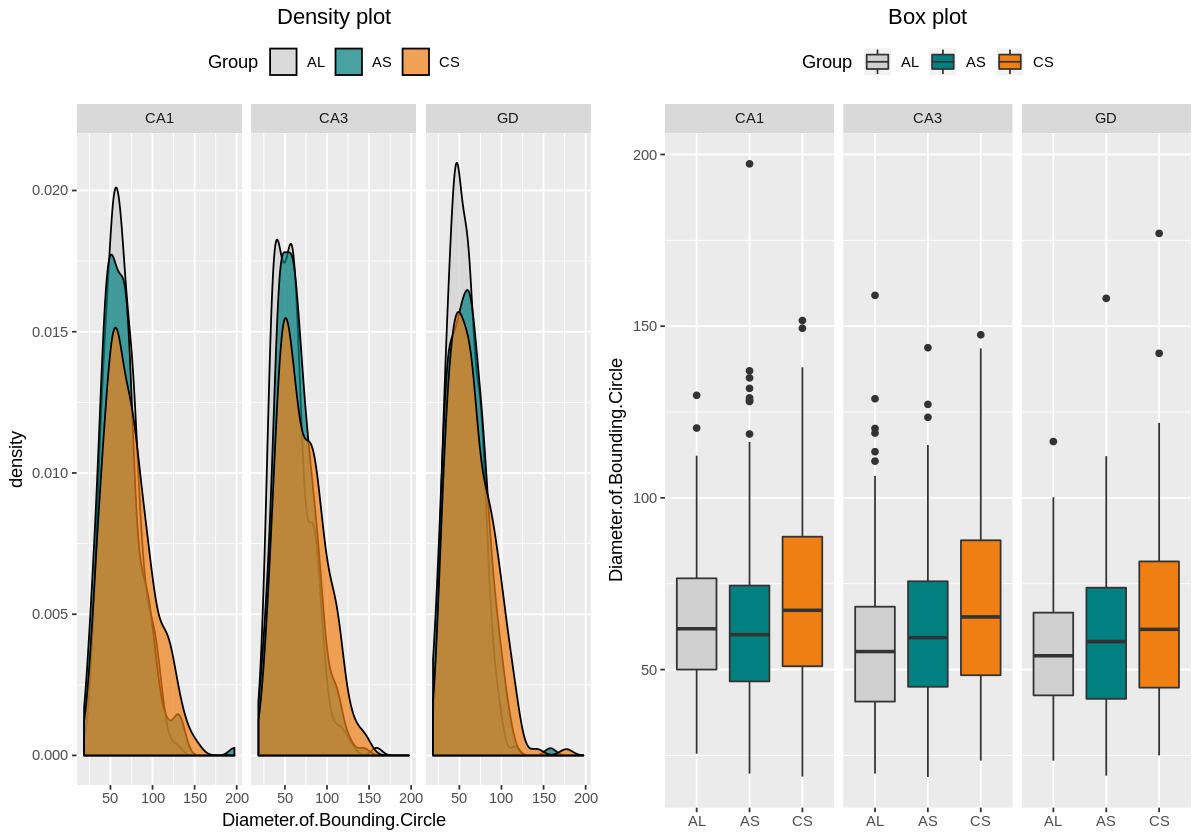

In [10]:
data.description <- mount.description(data, "Diameter.of.Bounding.Circle", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Diameter.of.Bounding.Circle", region = TRUE)
p2 <- custom.box.plot(data, "Diameter.of.Bounding.Circle", region = TRUE)

multiplot(p1,p2,cols = 2)

### Mean Radius
#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.  |   Var   |   Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:------:|:-------:|:------:|:-------:|:------:|:---:|
|  CS   | 8.704 | 20.944  | 28.083 | 29.769 | 37.168  | 75.856 | 129.154 | 11.365 | 720 |
|  AS   | 8.200 | 19.437  | 25.652 | 26.777 | 32.533  | 77.936 | 97.030  | 9.850  | 720 |
|  AL   | 8.691 | 19.044  | 25.030 | 25.656 | 30.879  | 69.231 | 73.885  | 8.596  | 720 |

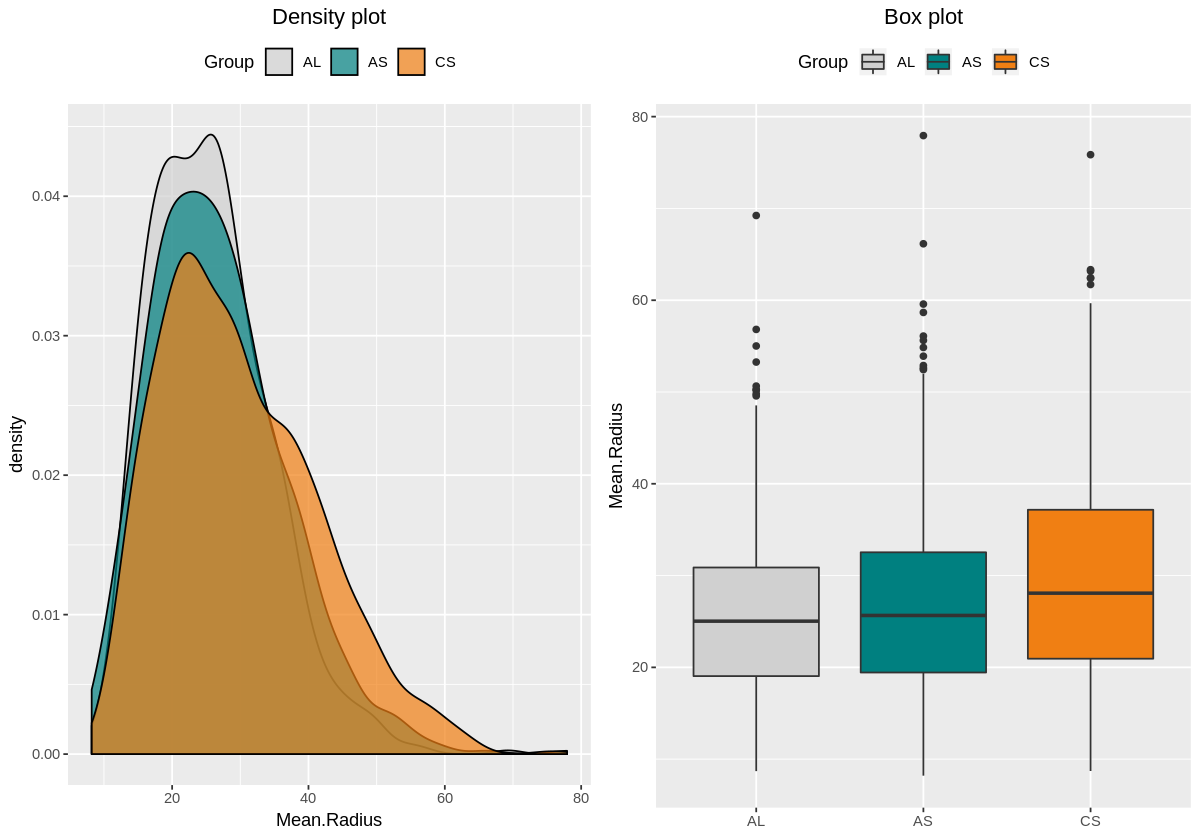

In [11]:
data.description <- mount.description(data, "Mean.Radius")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Mean.Radius")
p2 <- custom.box.plot(data, "Mean.Radius")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região |  Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.  |   Var   |   Sd   |  N  |
|:-----:|:------:|:------:|:-------:|:------:|:------:|:-------:|:------:|:-------:|:------:|:---:|
|  CS   |  CA1   | 8.704  | 22.203  | 29.692 | 30.904 | 37.448  | 63.328 | 134.629 | 11.603 | 240 |
|  CS   |  CA3   | 10.214 | 21.508  | 28.808 | 30.637 | 38.911  | 62.388 | 132.397 | 11.506 | 240 |
|  CS   |   GD   | 11.331 | 19.319  | 26.122 | 27.767 | 35.285  | 75.856 | 115.442 | 10.744 | 240 |
|  AS   |  CA1   | 8.711  | 20.006  | 25.894 | 27.628 | 33.505  | 77.936 | 110.929 | 10.532 | 240 |
|  AS   |  CA3   | 8.911  | 19.663  | 26.150 | 27.201 | 33.352  | 55.623 | 91.759  | 9.579  | 240 |
|  AS   |   GD   | 8.200  | 18.127  | 24.529 | 25.503 | 31.418  | 66.150 | 86.675  | 9.310  | 240 |
|  AL   |  CA1   | 11.285 | 21.045  | 26.651 | 27.682 | 33.275  | 55.014 | 73.402  | 8.568  | 240 |
|  AL   |  CA3   | 8.691  | 18.286  | 24.256 | 25.128 | 30.170  | 69.231 | 85.331  | 9.237  | 240 

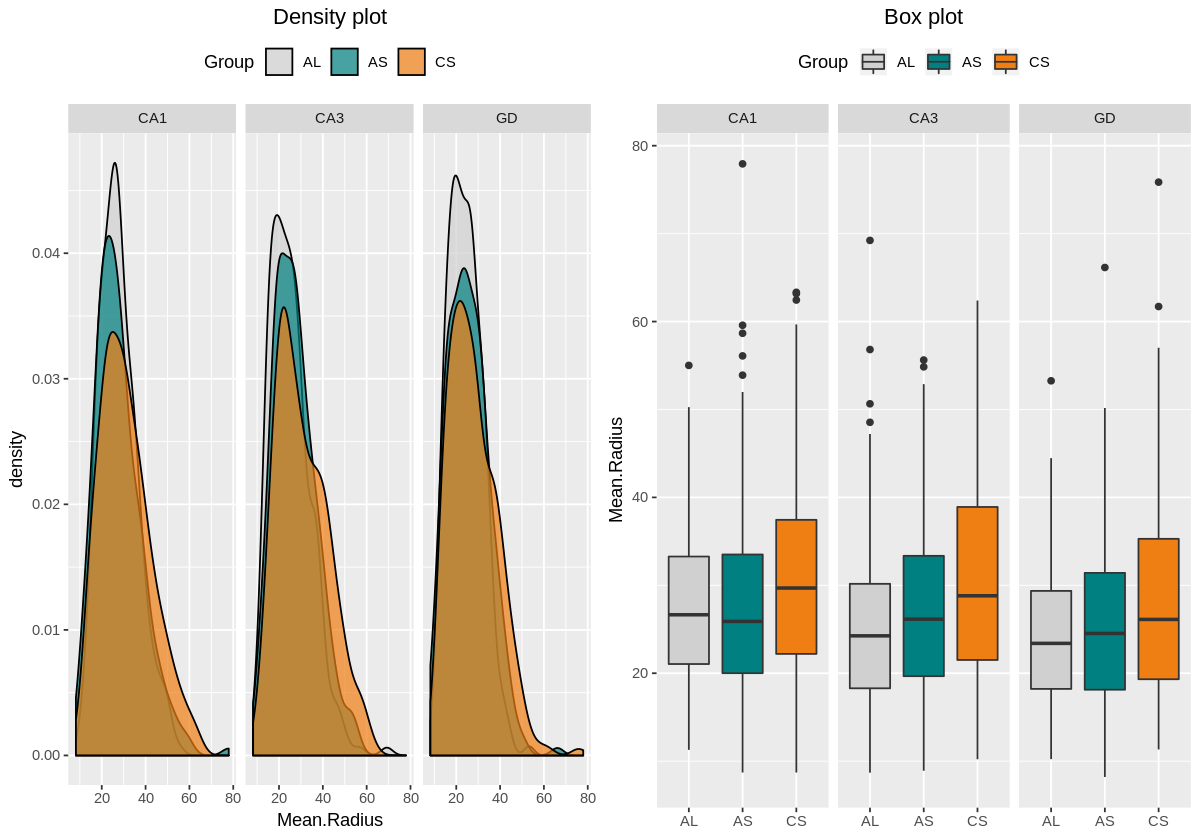

In [12]:
data.description <- mount.description(data, "Mean.Radius", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Mean.Radius", region = TRUE)
p2 <- custom.box.plot(data, "Mean.Radius", region = TRUE)

multiplot(p1,p2,cols = 2)

### Hull Void Area
#### Hippocampus



| Grupo | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:----:|:-------:|:------:|:-------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   | -24  |  211.5  |  571   | 886.526 | 1278.25 | 5439 | 873882.5 | 934.817 | 720 |
|  AS   | -28  |  140.0  |  432   | 637.183 | 896.00  | 4320 | 473498.8 | 688.112 | 720 |
|  AL   | -33  |  150.0  |  406   | 551.803 | 789.75  | 3129 | 296360.6 | 544.390 | 720 |

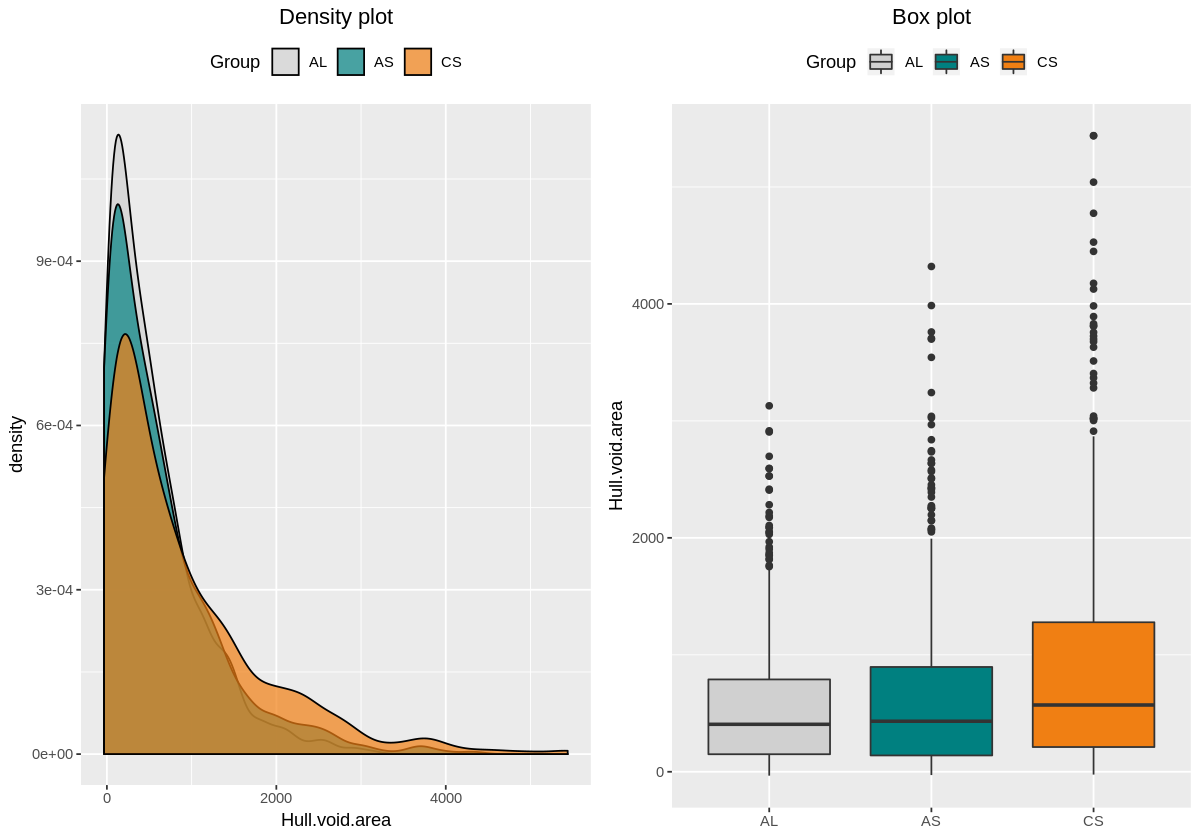

In [13]:
data.description <- mount.description(data,"Hull.void.area")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Hull.void.area")
p2 <- custom.box.plot(data, "Hull.void.area")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. | Max. |    Var    |    Sd    |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-------:|:-------:|:----:|:---------:|:--------:|:---:|
|  CS   |  CA1   | -24  | 259.00  | 642.5  | 975.379 | 1364.00 | 5439 | 1024429.1 | 1012.141 | 240 |
|  CS   |  CA3   | -21  | 222.75  | 611.0  | 952.175 | 1379.75 | 5041 | 963919.3  | 981.794  | 240 |
|  CS   |   GD   | -23  | 160.25  | 483.5  | 732.025 | 1057.25 | 3892 | 604385.8  | 777.423  | 240 |
|  AS   |  CA1   | -18  | 175.25  | 469.5  | 693.892 | 1045.50 | 3706 | 539704.3  | 734.646  | 240 |
|  AS   |  CA3   | -28  | 145.00  | 450.5  | 670.267 | 947.50  | 4320 | 505583.6  | 711.044  | 240 |
|  AS   |   GD   | -26  |  95.25  | 395.5  | 547.392 | 778.75  | 3986 | 366746.2  | 605.596  | 240 |
|  AL   |  CA1   | -21  | 228.75  | 514.0  | 673.771 | 881.25  | 2915 | 348694.8  | 590.504  | 240 |
|  AL   |  CA3   | -31  | 100.00  | 275.0  | 504.604 | 676.25  | 3129 | 318253.7  | 564.1

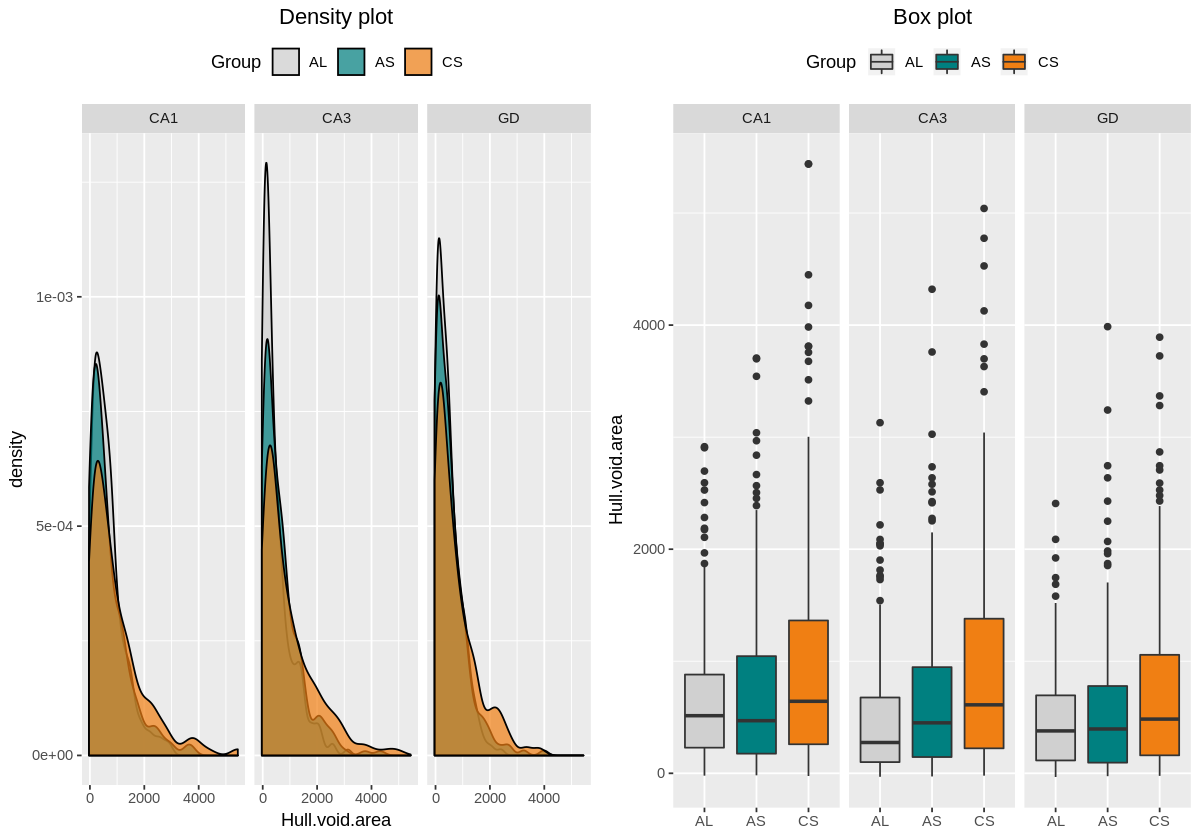

In [14]:
data.description <- mount.description(data, "Hull.void.area", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Hull.void.area", region = TRUE)
p2 <- custom.box.plot(data, "Hull.void.area", region = TRUE)

multiplot(p1,p2,cols = 2)

### Cell Area
#### Hippocampus



| Grupo | Min. | 1st Qu. | Median |   Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:----:|:-------:|:------:|:--------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   | 170  | 674.00  | 1025.5 | 1126.206 | 1436.75 | 4239 | 360241.6 | 600.201 | 720 |
|  AS   | 177  | 646.75  | 872.5  | 974.599  | 1253.00 | 3127 | 225147.0 | 474.497 | 720 |
|  AL   | 214  | 596.00  | 814.5  | 877.967  | 1085.50 | 2186 | 133070.2 | 364.788 | 720 |

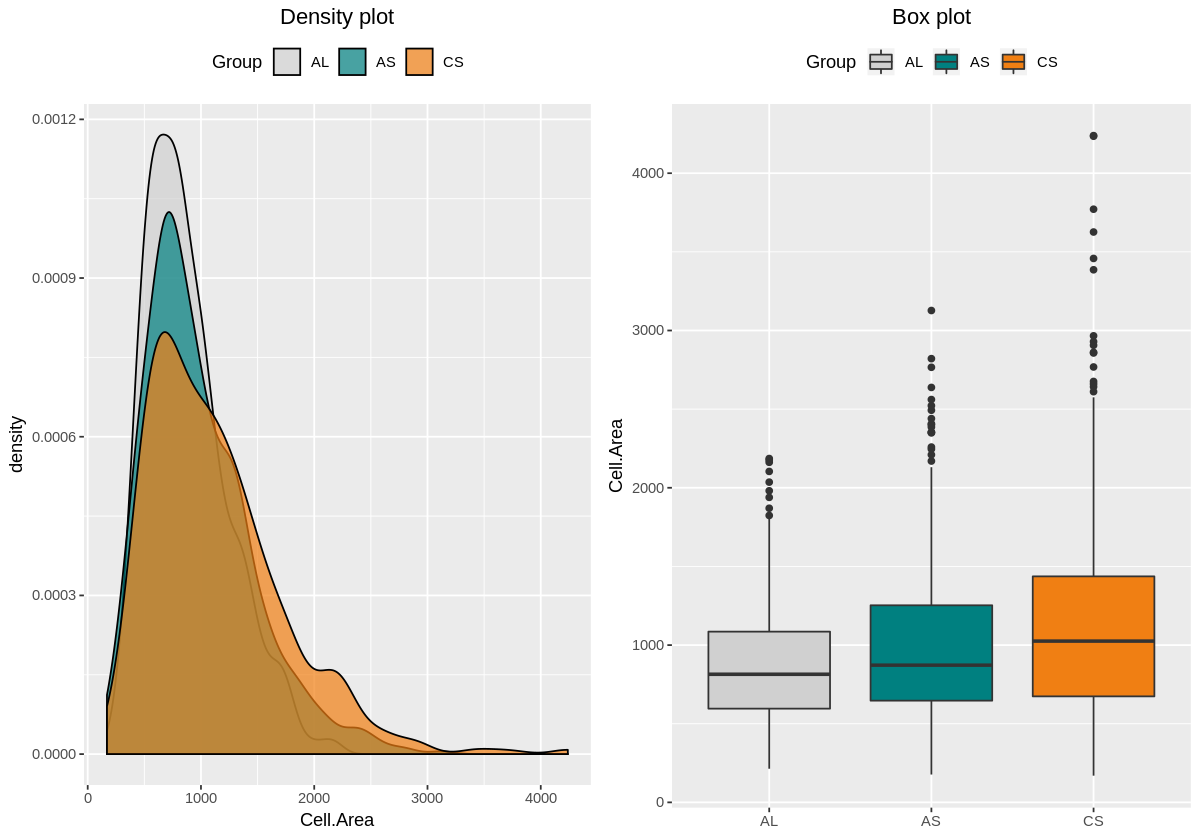

In [15]:
data.description <- mount.description(data,"Cell.Area")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Cell.Area")
p2 <- custom.box.plot(data, "Cell.Area")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median |   Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:--------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   |  CA1   | 170  | 680.75  | 1035.5 | 1149.112 | 1443.25 | 4235 | 416476.3 | 645.350 | 240 |
|  CS   |  CA3   | 195  | 719.50  | 1063.5 | 1163.604 | 1493.00 | 2966 | 322686.0 | 568.055 | 240 |
|  CS   |   GD   | 228  | 616.00  | 923.0  | 1065.900 | 1362.50 | 4239 | 338993.8 | 582.232 | 240 |
|  AS   |  CA1   | 231  | 665.75  | 903.5  | 1014.538 | 1290.25 | 3127 | 254632.0 | 504.611 | 240 |
|  AS   |  CA3   | 218  | 650.00  | 896.5  | 983.121  | 1224.25 | 2766 | 237498.7 | 487.338 | 240 |
|  AS   |   GD   | 177  | 624.75  | 836.0  | 926.138  | 1244.00 | 2401 | 181161.2 | 425.630 | 240 |
|  AL   |  CA1   | 287  | 632.50  | 876.5  | 946.496  | 1177.75 | 2186 | 160187.7 | 400.235 | 240 |
|  AL   |  CA3   | 214  | 589.50  | 768.0  | 851.479  | 1065.50 | 2104 | 124333.6 | 352.610 | 240 

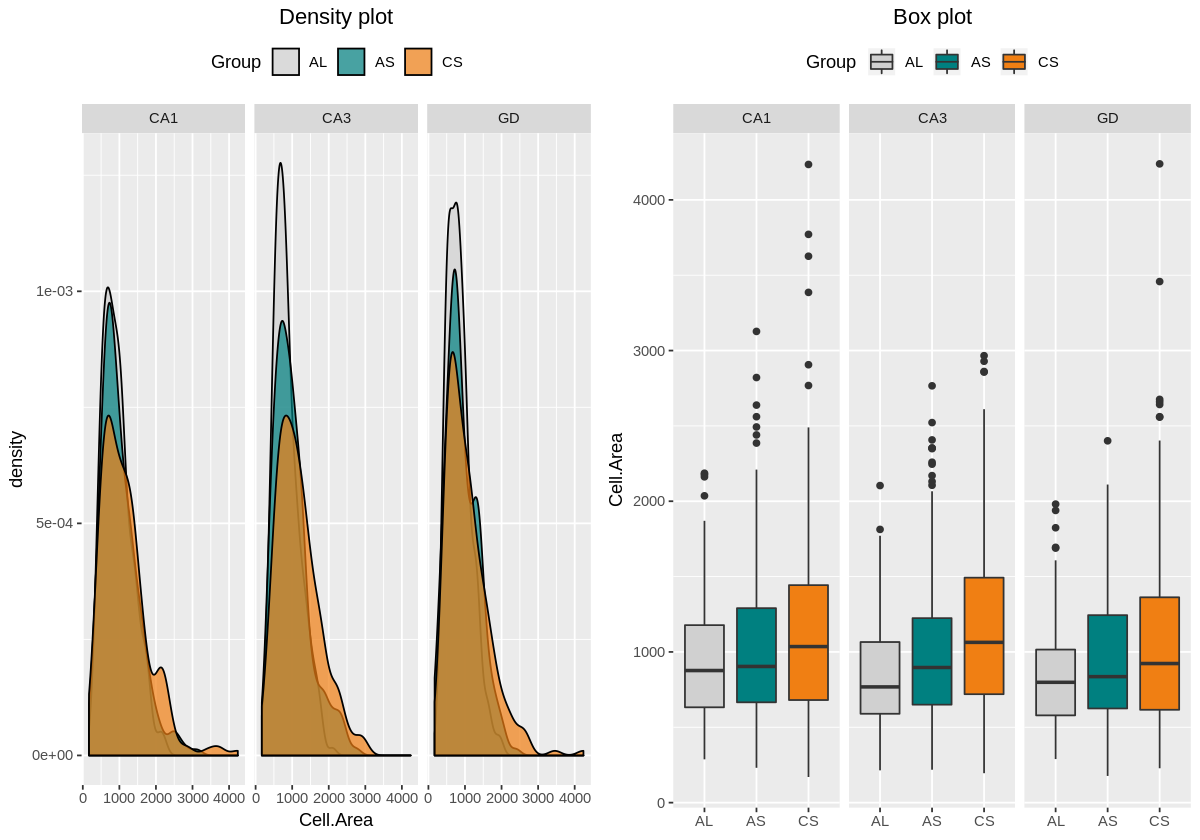

In [16]:
data.description <- mount.description(data, "Cell.Area", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Cell.Area", region = TRUE)
p2 <- custom.box.plot(data, "Cell.Area", region = TRUE)

multiplot(p1,p2,cols = 2)

### Cell Perimeter
#### Hippocampus



| Grupo |  Min.  | 1st Qu. | Median  |  Mean   | 3rd Qu. |   Max.   |   Var    |   Sd    |  N  |
|:-----:|:------:|:-------:|:-------:|:-------:|:-------:|:--------:|:--------:|:-------:|:---:|
|  CS   | 53.355 | 157.863 | 236.007 | 285.629 | 363.885 | 1185.291 | 30600.93 | 174.931 | 720 |
|  AS   | 53.355 | 140.666 | 207.694 | 239.476 | 306.216 | 814.531  | 17331.07 | 131.648 | 720 |
|  AL   | 56.870 | 139.899 | 200.058 | 225.347 | 284.090 | 707.619  | 12547.65 | 112.016 | 720 |

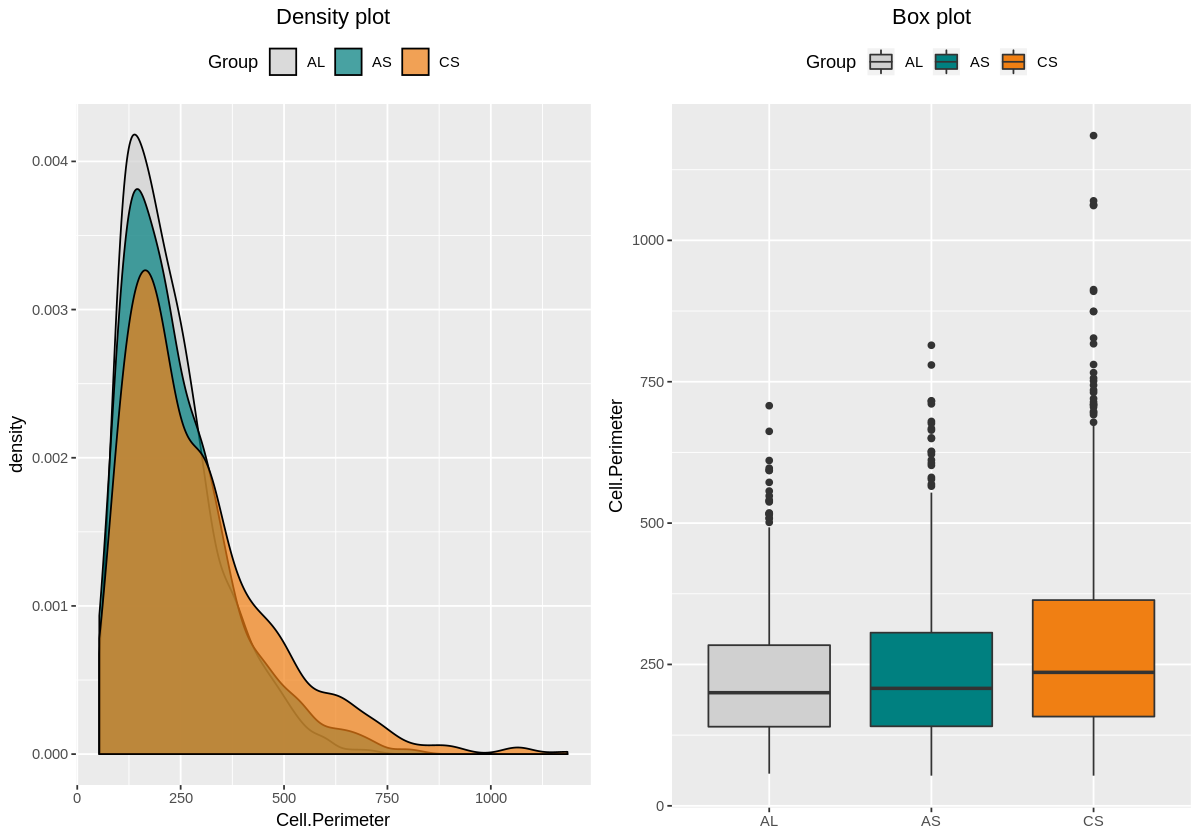

In [17]:
data.description <- mount.description(data,"Cell.Perimeter")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Cell.Perimeter")
p2 <- custom.box.plot(data, "Cell.Perimeter")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região |  Min.  | 1st Qu. | Median  |  Mean   | 3rd Qu. |   Max.   |   Var    |   Sd    |  N  |
|:-----:|:------:|:------:|:-------:|:-------:|:-------:|:-------:|:--------:|:--------:|:-------:|:---:|
|  CS   |  CA1   | 53.355 | 165.349 | 251.392 | 301.858 | 390.619 | 1185.291 | 35341.40 | 187.993 | 240 |
|  CS   |  CA3   | 66.426 | 159.288 | 240.543 | 287.207 | 360.814 | 909.970  | 27659.56 | 166.312 | 240 |
|  CS   |   GD   | 77.598 | 142.752 | 219.522 | 267.822 | 347.046 | 1069.935 | 28472.53 | 168.738 | 240 |
|  AS   |  CA1   | 57.355 | 145.242 | 217.451 | 251.635 | 320.061 | 814.531  | 20571.20 | 143.427 | 240 |
|  AS   |  CA3   | 58.527 | 140.710 | 207.007 | 241.480 | 307.818 | 716.306  | 17010.28 | 130.423 | 240 |
|  AS   |   GD   | 53.355 | 134.338 | 197.250 | 225.312 | 295.262 | 679.820  | 14202.83 | 119.176 | 240 |
|  AL   |  CA1   | 72.669 | 165.298 | 224.835 | 254.288 | 307.333 | 707.619  | 14535.03 | 120.561 | 240 |
|  AL   |  CA3   | 56.870 | 126.418 | 175.06

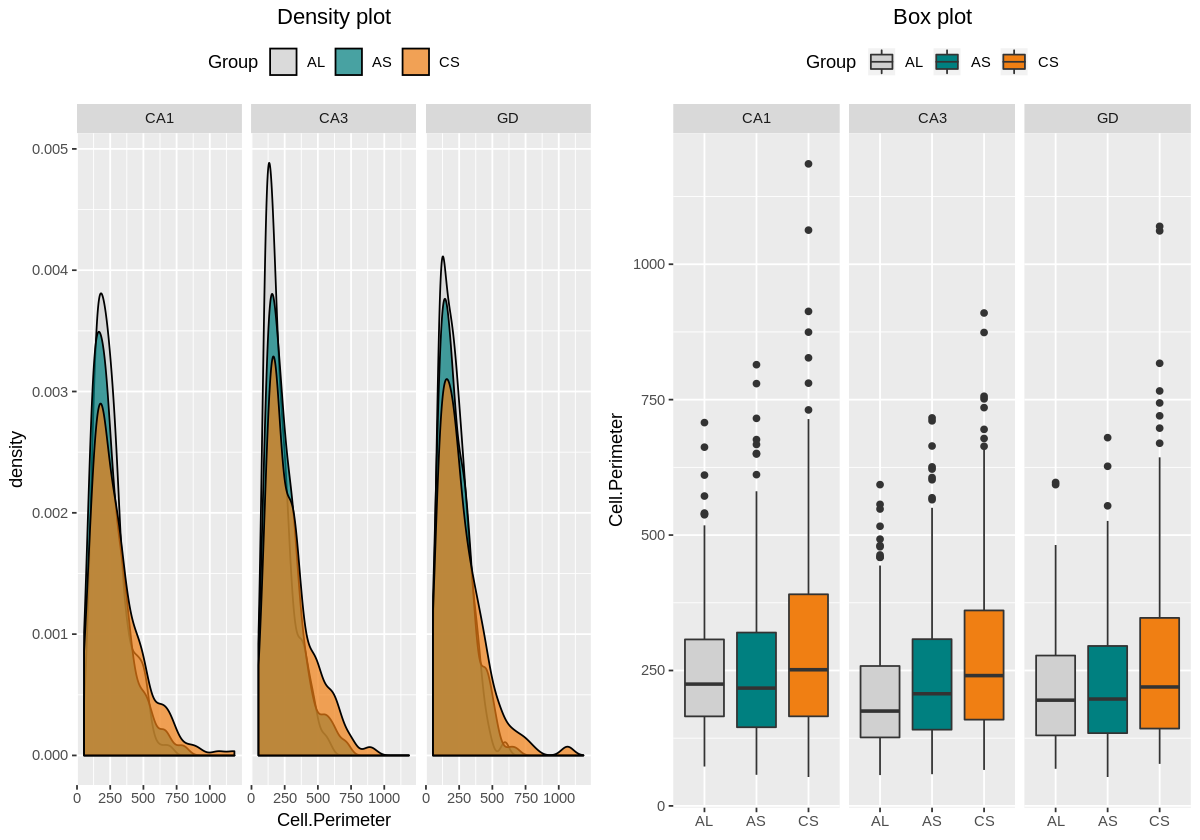

In [18]:
data.description <- mount.description(data, "Cell.Perimeter", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Cell.Perimeter", region = TRUE)
p2 <- custom.box.plot(data, "Cell.Perimeter", region = TRUE)

multiplot(p1,p2,cols = 2)

### Solidity
#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   | 0.278 |  0.485  | 0.591  | 0.607 |  0.714  | 0.953 | 0.025 | 0.158 | 720 |
|  AS   | 0.263 |  0.525  | 0.622  | 0.642 |  0.761  | 0.957 | 0.024 | 0.155 | 720 |
|  AL   | 0.281 |  0.518  | 0.619  | 0.638 |  0.751  | 0.966 | 0.023 | 0.150 | 720 |

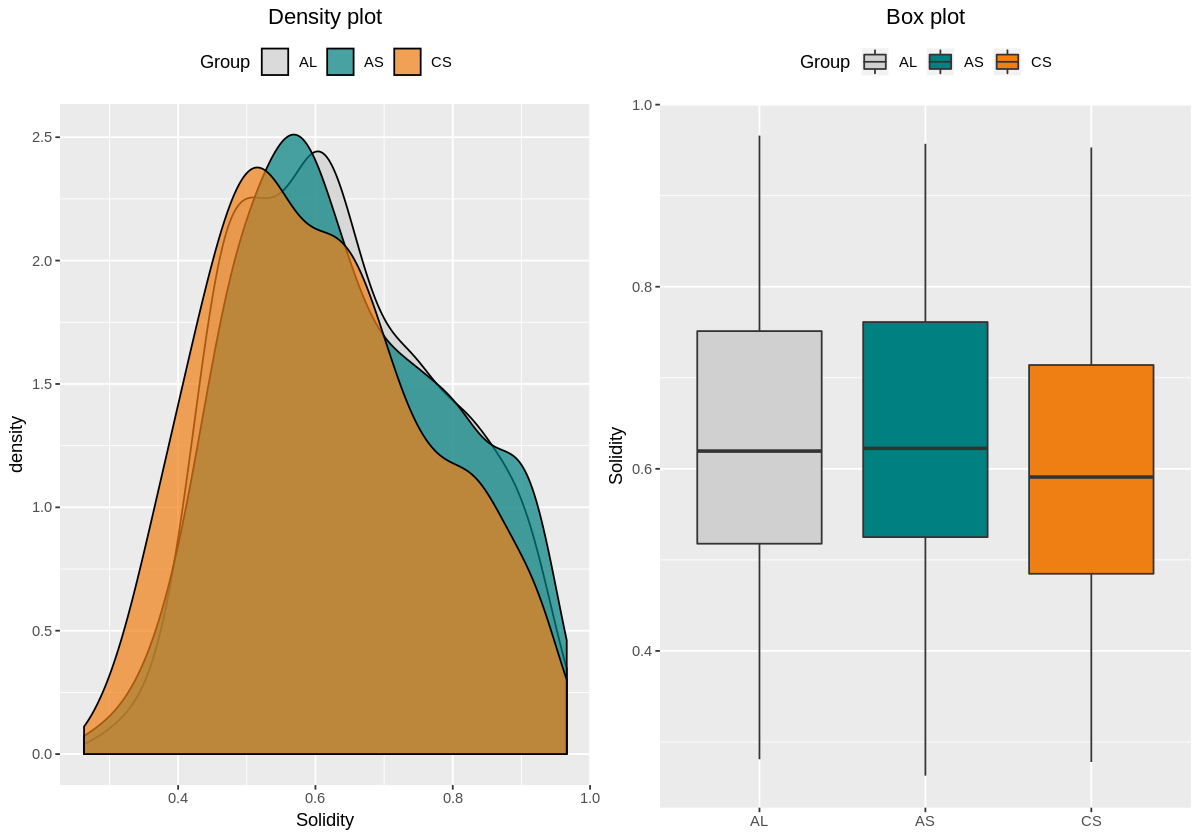

In [19]:
data.description <- mount.description(data,"Solidity")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Solidity")
p2 <- custom.box.plot(data, "Solidity")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:------:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   |  CA1   | 0.278 |  0.460  | 0.565  | 0.586 |  0.682  | 0.945 | 0.024 | 0.156 | 240 |
|  CS   |  CA3   | 0.294 |  0.475  | 0.595  | 0.598 |  0.712  | 0.953 | 0.024 | 0.154 | 240 |
|  CS   |   GD   | 0.345 |  0.508  | 0.621  | 0.637 |  0.760  | 0.950 | 0.025 | 0.158 | 240 |
|  AS   |  CA1   | 0.263 |  0.514  | 0.619  | 0.634 |  0.742  | 0.942 | 0.024 | 0.156 | 240 |
|  AS   |  CA3   | 0.298 |  0.507  | 0.600  | 0.630 |  0.760  | 0.957 | 0.024 | 0.156 | 240 |
|  AS   |   GD   | 0.349 |  0.546  | 0.640  | 0.662 |  0.791  | 0.950 | 0.023 | 0.153 | 240 |
|  AL   |  CA1   | 0.316 |  0.486  | 0.578  | 0.599 |  0.678  | 0.941 | 0.019 | 0.138 | 240 |
|  AL   |  CA3   | 0.281 |  0.534  | 0.670  | 0.662 |  0.794  | 0.962 | 0.025 | 0.157 | 240 |
|  AL   |   GD   | 0.382 |  0.544  | 0.631  | 0.653 |  0.7

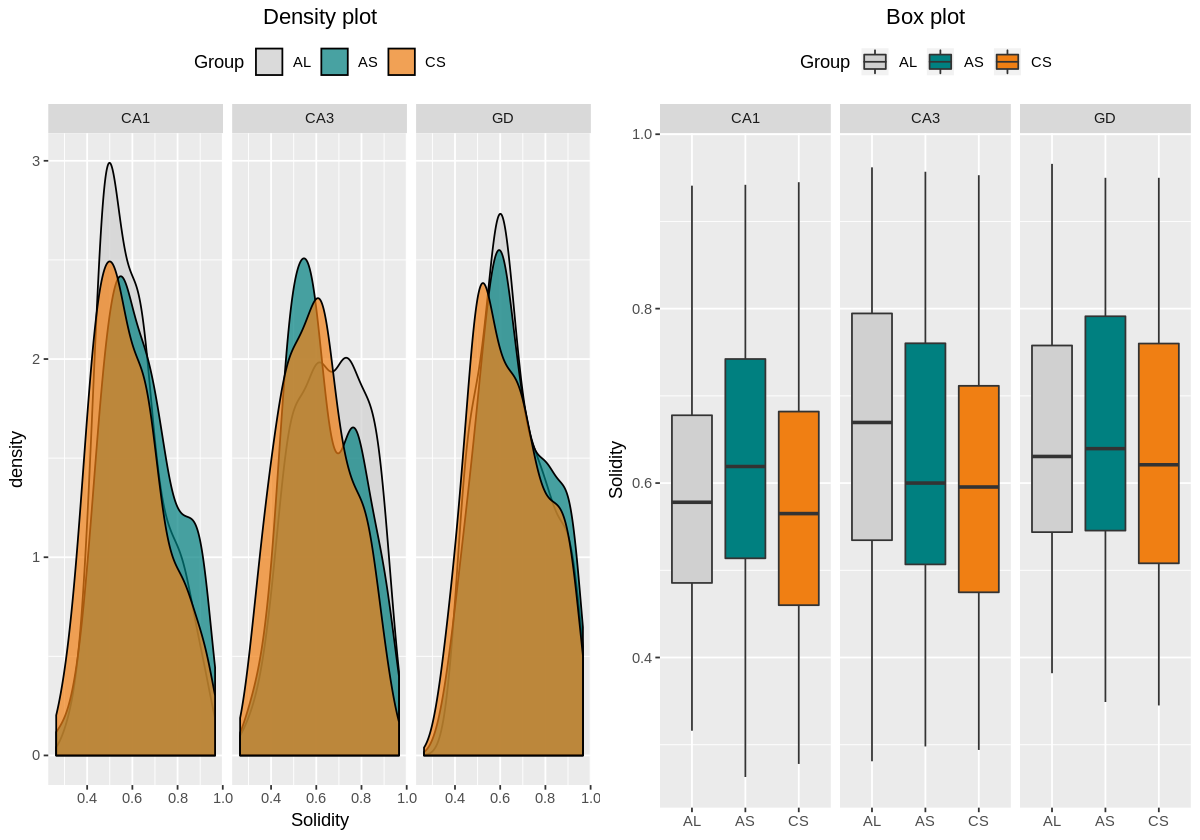

In [20]:
data.description <- mount.description(data, "Solidity", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Solidity", region = TRUE)
p2 <- custom.box.plot(data, "Solidity", region = TRUE)

multiplot(p1,p2,cols = 2)

### Round
#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   | 0.099 |  0.413  | 0.544  | 0.551 |  0.688  | 0.975 | 0.032 | 0.178 | 720 |
|  AS   | 0.123 |  0.419  | 0.546  | 0.553 |  0.684  | 0.987 | 0.033 | 0.182 | 720 |
|  AL   | 0.120 |  0.423  | 0.549  | 0.551 |  0.673  | 0.976 | 0.029 | 0.171 | 720 |

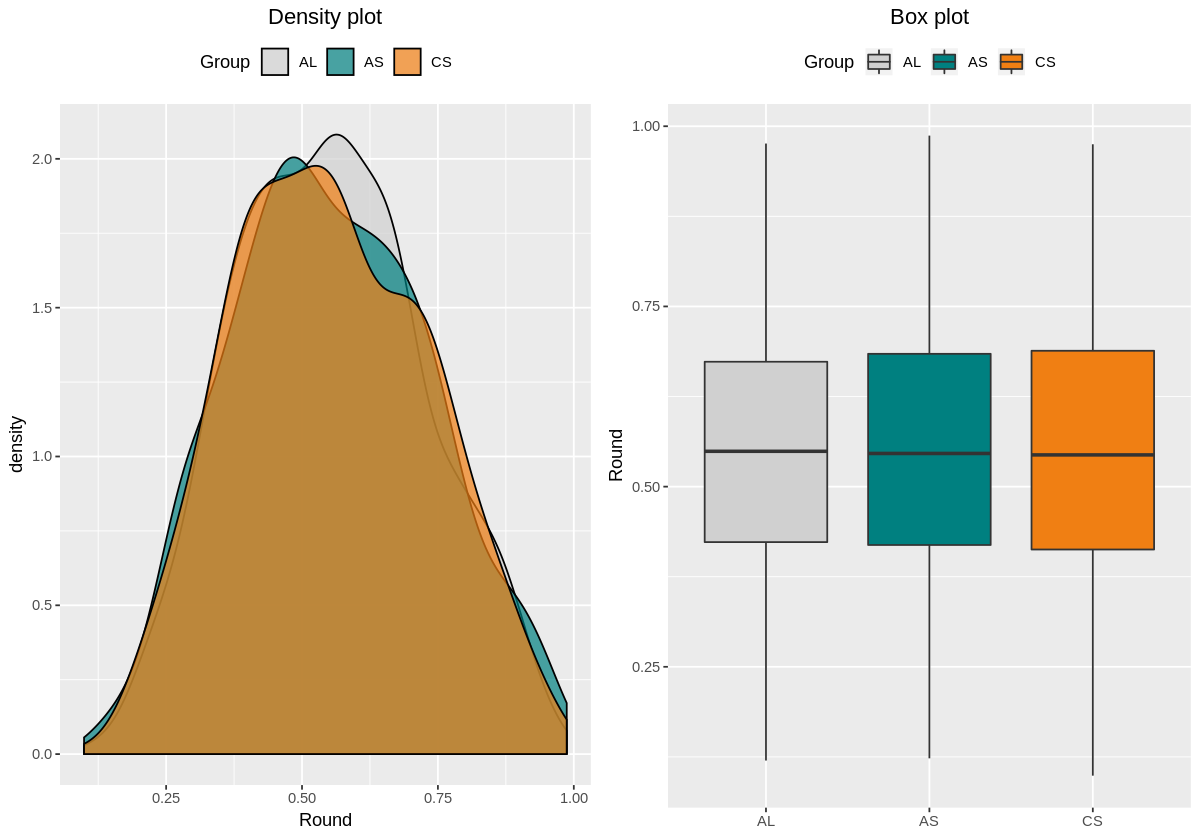

In [21]:
data.description <- mount.description(data,"Round")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Round")
p2 <- custom.box.plot(data, "Round")

multiplot(p1,p2,cols = 2)


#### Regions



| Grupo | Região | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:------:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   |  CA1   | 0.099 |  0.397  | 0.530  | 0.530 |  0.665  | 0.921 | 0.031 | 0.175 | 240 |
|  CS   |  CA3   | 0.205 |  0.428  | 0.545  | 0.556 |  0.688  | 0.975 | 0.030 | 0.173 | 240 |
|  CS   |   GD   | 0.177 |  0.434  | 0.556  | 0.567 |  0.704  | 0.967 | 0.034 | 0.184 | 240 |
|  AS   |  CA1   | 0.129 |  0.426  | 0.539  | 0.557 |  0.686  | 0.987 | 0.034 | 0.185 | 240 |
|  AS   |  CA3   | 0.123 |  0.404  | 0.548  | 0.543 |  0.676  | 0.968 | 0.033 | 0.181 | 240 |
|  AS   |   GD   | 0.174 |  0.432  | 0.542  | 0.559 |  0.694  | 0.964 | 0.032 | 0.179 | 240 |
|  AL   |  CA1   | 0.178 |  0.403  | 0.510  | 0.524 |  0.637  | 0.976 | 0.026 | 0.162 | 240 |
|  AL   |  CA3   | 0.135 |  0.430  | 0.562  | 0.561 |  0.687  | 0.949 | 0.034 | 0.183 | 240 |
|  AL   |   GD   | 0.120 |  0.446  | 0.567  | 0.570 |  0.6

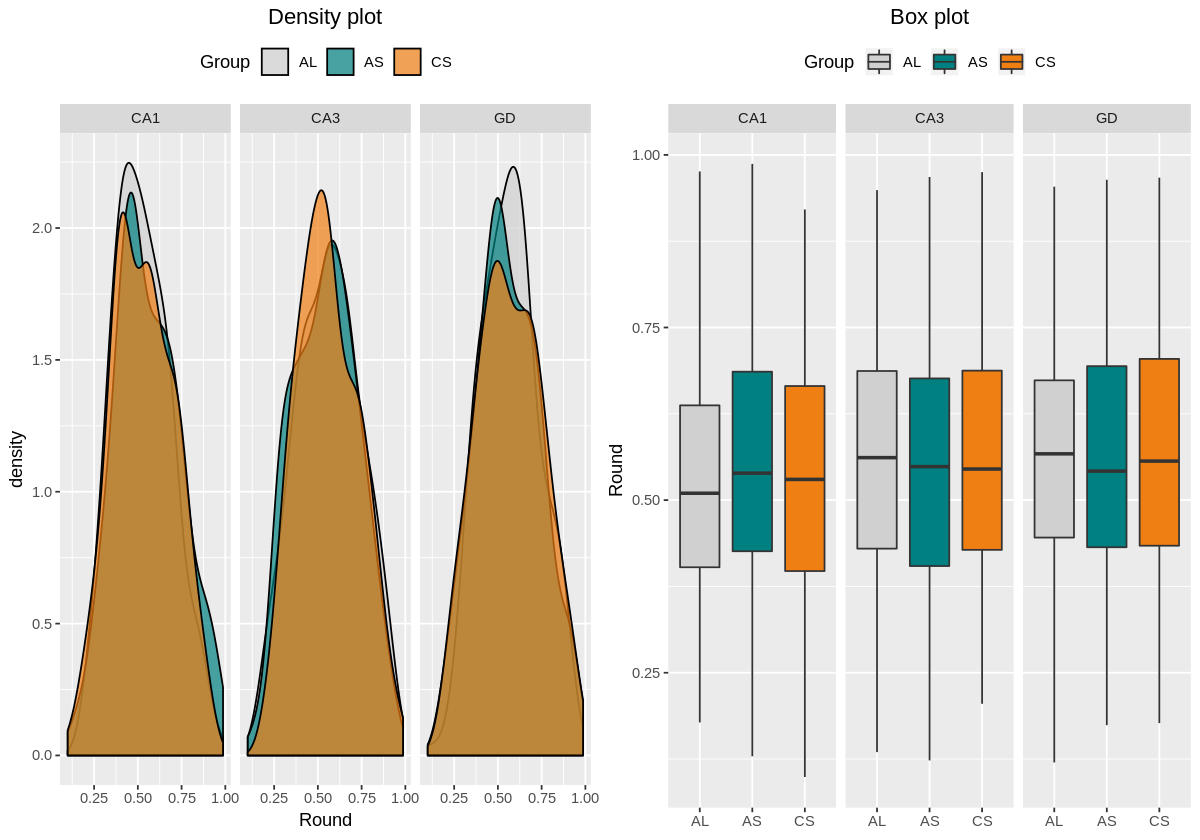

In [22]:
data.description <- mount.description(data, "Round", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Round", region = TRUE)
p2 <- custom.box.plot(data, "Round", region = TRUE)

multiplot(p1,p2,cols = 2)

### Circularity
#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   | 0.038 |  0.125  | 0.212  | 0.274 |  0.379  | 0.902 | 0.039 | 0.198 | 720 |
|  AS   | 0.050 |  0.151  | 0.245  | 0.315 |  0.438  | 0.892 | 0.046 | 0.214 | 720 |
|  AL   | 0.049 |  0.152  | 0.244  | 0.311 |  0.424  | 0.922 | 0.041 | 0.203 | 720 |

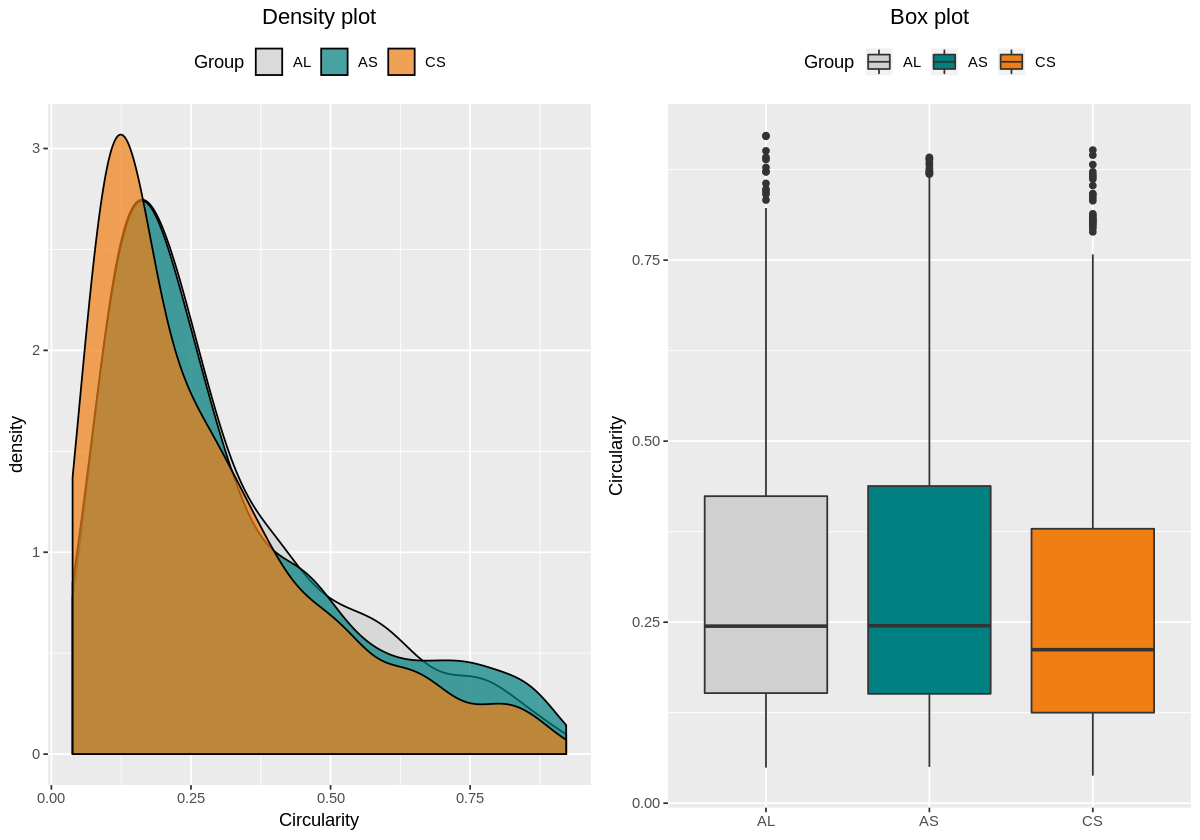

In [23]:
data.description <- mount.description(data,"Circularity")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Circularity")
p2 <- custom.box.plot(data, "Circularity")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:------:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   |  CA1   | 0.038 |  0.114  | 0.192  | 0.252 |  0.342  | 0.865 | 0.036 | 0.189 | 240 |
|  CS   |  CA3   | 0.040 |  0.129  | 0.223  | 0.270 |  0.383  | 0.902 | 0.033 | 0.180 | 240 |
|  CS   |   GD   | 0.039 |  0.132  | 0.236  | 0.301 |  0.414  | 0.895 | 0.048 | 0.220 | 240 |
|  AS   |  CA1   | 0.050 |  0.144  | 0.240  | 0.304 |  0.424  | 0.885 | 0.044 | 0.209 | 240 |
|  AS   |  CA3   | 0.053 |  0.148  | 0.243  | 0.305 |  0.435  | 0.892 | 0.042 | 0.204 | 240 |
|  AS   |   GD   | 0.054 |  0.160  | 0.250  | 0.337 |  0.462  | 0.890 | 0.052 | 0.227 | 240 |
|  AL   |  CA1   | 0.051 |  0.133  | 0.207  | 0.252 |  0.309  | 0.833 | 0.028 | 0.168 | 240 |
|  AL   |  CA3   | 0.069 |  0.177  | 0.302  | 0.351 |  0.508  | 0.921 | 0.043 | 0.208 | 240 |
|  AL   |   GD   | 0.049 |  0.164  | 0.248  | 0.329 |  0.4

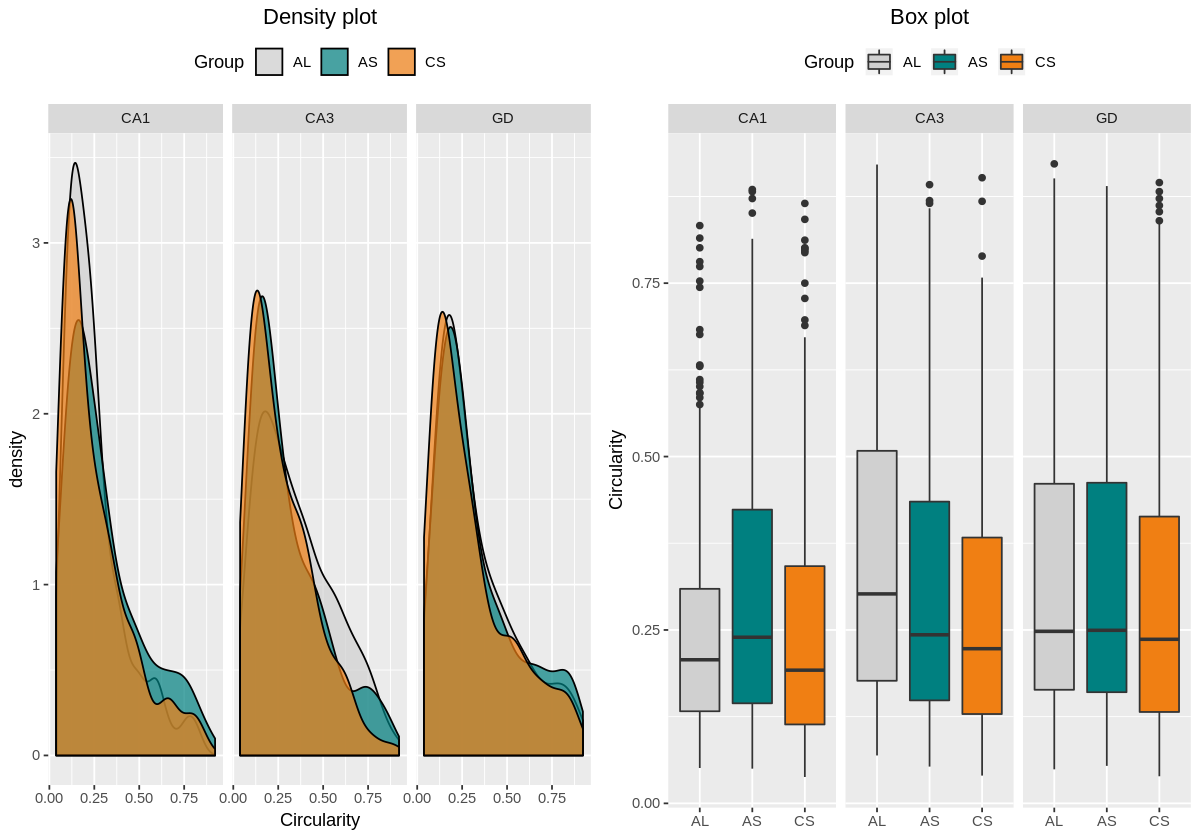

In [24]:
data.description <- mount.description(data, "Circularity", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Circularity", region = TRUE)
p2 <- custom.box.plot(data, "Circularity", region = TRUE)

multiplot(p1,p2,cols = 2)

### Branches
#### Hippocampus



| Grupo | Min. | 1st Qu. | Median |  Mean  | 3rd Qu. | Max. |   Var   |   Sd   |  N  |
|:-----:|:----:|:-------:|:------:|:------:|:-------:|:----:|:-------:|:------:|:---:|
|  CS   |  1   |    5    |   10   | 13.025 |   18    |  83  | 124.695 | 11.167 | 720 |
|  AS   |  1   |    4    |   9    | 10.736 |   15    |  55  | 81.093  | 9.005  | 720 |
|  AL   |  1   |    4    |   8    | 9.522  |   13    |  40  | 52.069  | 7.216  | 720 |

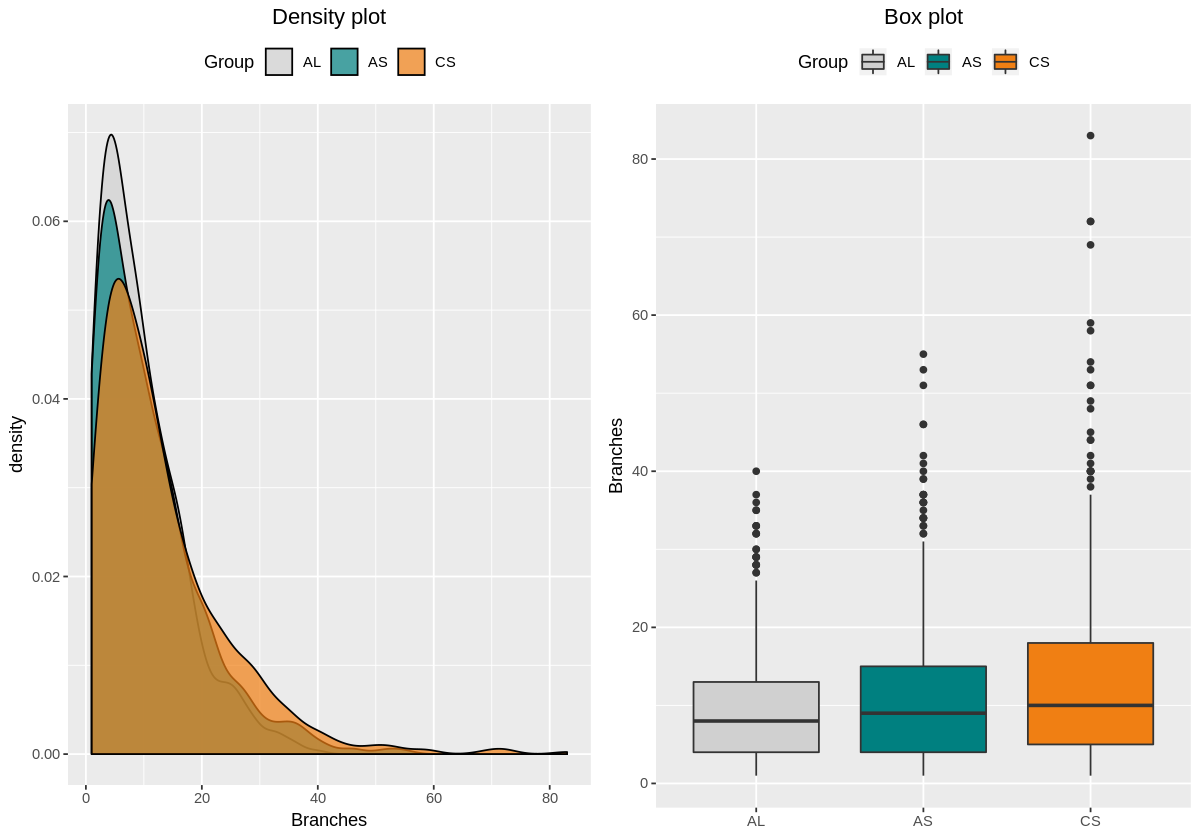

In [25]:
data.description <- mount.description(data,"Branches")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Branches")
p2 <- custom.box.plot(data, "Branches")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median |  Mean  | 3rd Qu. | Max. |   Var   |   Sd   |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:------:|:-------:|:----:|:-------:|:------:|:---:|
|  CS   |  CA1   |  1   |  5.00   |  11.0  | 13.912 |  18.25  |  72  | 145.704 | 12.071 | 240 |
|  CS   |  CA3   |  1   |  5.00   |  10.0  | 12.558 |  17.00  |  54  | 92.884  | 9.638  | 240 |
|  CS   |   GD   |  1   |  5.00   |  9.0   | 12.604 |  17.00  |  83  | 135.353 | 11.634 | 240 |
|  AS   |  CA1   |  1   |  4.75   |  9.0   | 11.512 |  15.00  |  55  | 104.527 | 10.224 | 240 |
|  AS   |  CA3   |  1   |  4.00   |  9.0   | 10.704 |  15.00  |  41  | 73.314  | 8.562  | 240 |
|  AS   |   GD   |  1   |  3.00   |  8.0   | 9.992  |  14.00  |  39  | 64.954  | 8.059  | 240 |
|  AL   |  CA1   |  1   |  5.00   |  10.0  | 11.717 |  16.00  |  40  | 70.748  | 8.411  | 240 |
|  AL   |  CA3   |  1   |  3.00   |  6.0   | 8.042  |  11.00  |  32  | 40.618  | 6.373  | 240 |
|  AL   |   GD   |  1   |  3.00   |  7

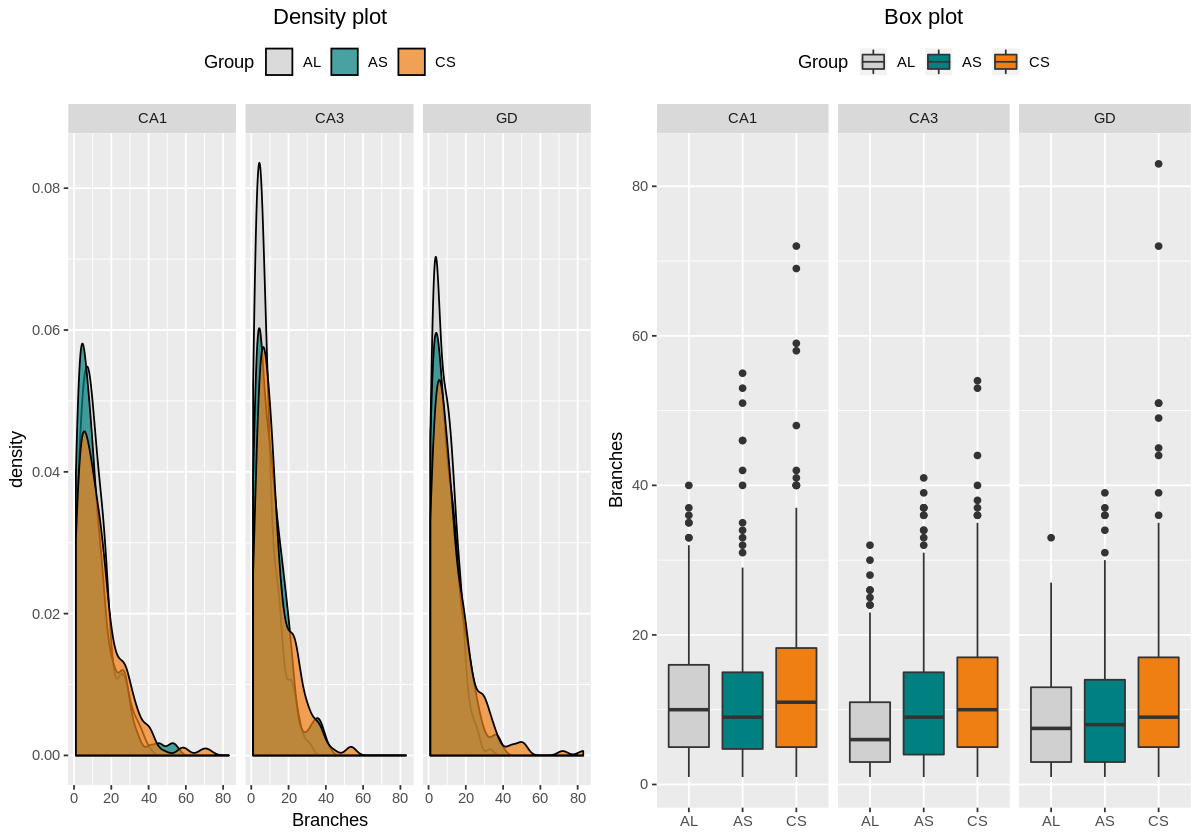

In [26]:
data.description <- mount.description(data, "Branches", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Branches", region = TRUE)
p2 <- custom.box.plot(data, "Branches", region = TRUE)

multiplot(p1,p2,cols = 2)

### Junctions
#### Hippocampus



| Grupo | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var   |  Sd   |  N  |
|:-----:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:------:|:-----:|:---:|
|  CS   |  0   |    2    |   4    | 5.974 |    8    |  44  | 32.098 | 5.666 | 720 |
|  AS   |  0   |    1    |   4    | 4.778 |    7    |  28  | 20.023 | 4.475 | 720 |
|  AL   |  0   |    1    |   3    | 4.213 |    6    |  20  | 13.108 | 3.620 | 720 |

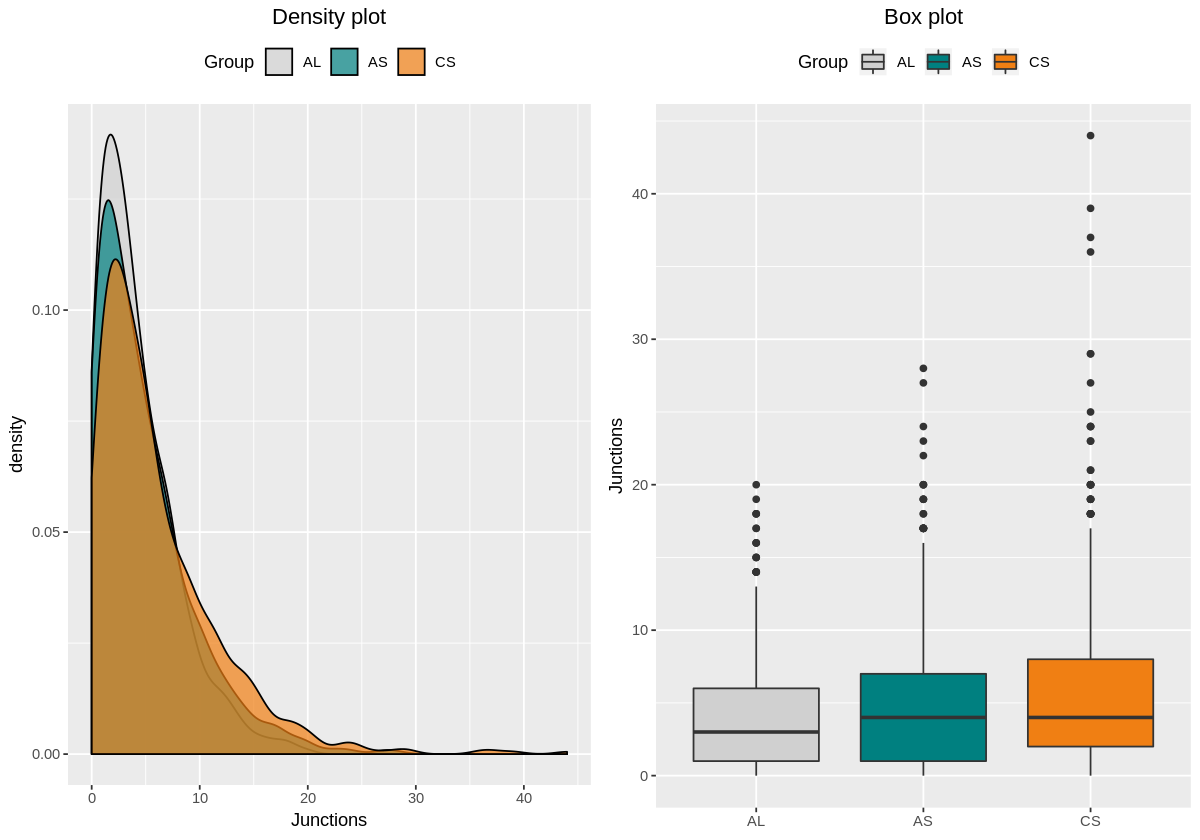

In [27]:
data.description <- mount.description(data,"Junctions") 

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Junctions")
p2 <- custom.box.plot(data, "Junctions")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var   |  Sd   |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:------:|:-----:|:---:|
|  CS   |  CA1   |  0   |  2.00   |   5    | 6.417 |    9    |  39  | 37.391 | 6.115 | 240 |
|  CS   |  CA3   |  0   |  2.00   |   4    | 5.713 |    8    |  27  | 22.833 | 4.778 | 240 |
|  CS   |   GD   |  0   |  2.00   |   4    | 5.792 |    8    |  44  | 36.040 | 6.003 | 240 |
|  AS   |  CA1   |  0   |  1.75   |   4    | 5.146 |    7    |  28  | 25.941 | 5.093 | 240 |
|  AS   |  CA3   |  0   |  1.00   |   4    | 4.750 |    7    |  20  | 18.113 | 4.256 | 240 |
|  AS   |   GD   |  0   |  1.00   |   3    | 4.438 |    6    |  20  | 15.929 | 3.991 | 240 |
|  AL   |  CA1   |  0   |  2.00   |   4    | 5.325 |    7    |  20  | 18.019 | 4.245 | 240 |
|  AL   |  CA3   |  0   |  1.00   |   3    | 3.454 |    5    |  16  | 9.881  | 3.143 | 240 |
|  AL   |   GD   |  0   |  1.00   |   3    | 3.858 |    6    |  18  

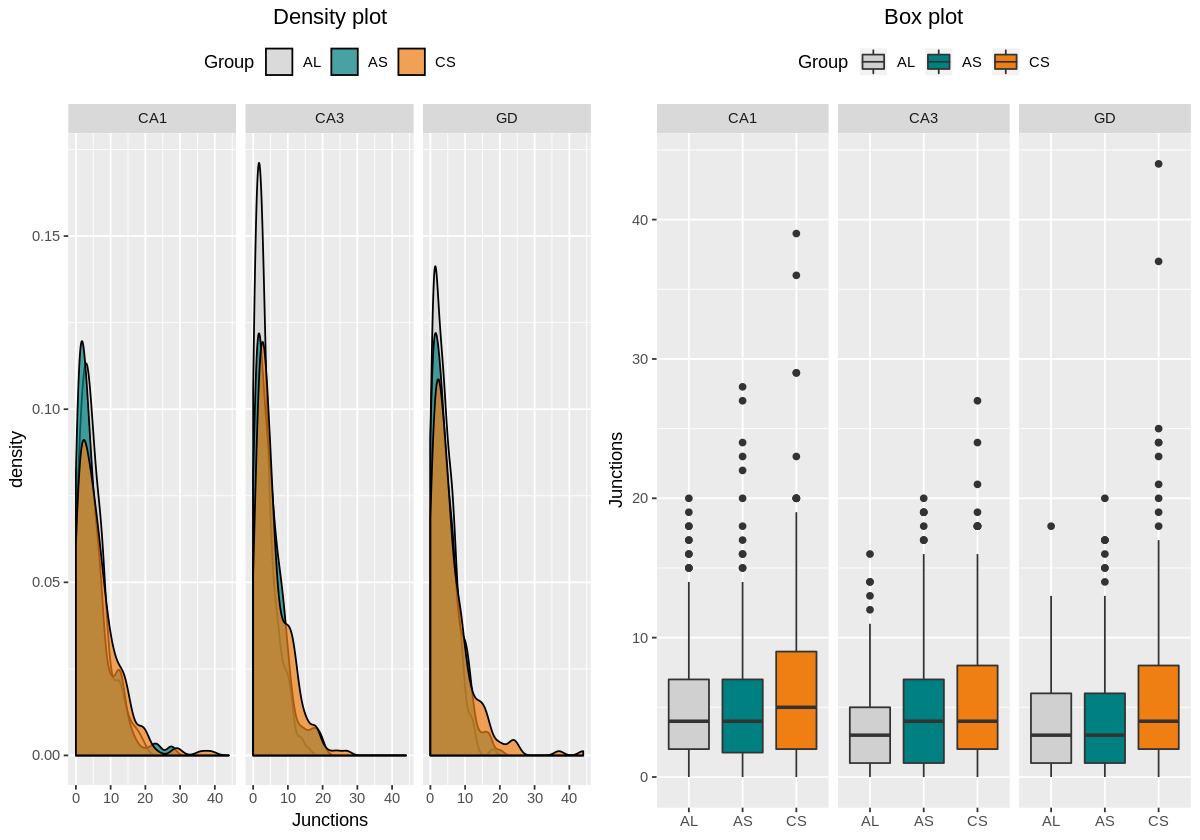

In [28]:
data.description <- mount.description(data, "Junctions", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Junctions", region = TRUE)
p2 <- custom.box.plot(data, "Junctions", region = TRUE)

multiplot(p1,p2,cols = 2)

### Triple Points
#### Hippocampus



| Grupo | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var   |  Sd   |  N  |
|:-----:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:------:|:-----:|:---:|
|  CS   |  0   |    2    |   4    | 5.286 |    7    |  36  | 24.675 | 4.967 | 720 |
|  AS   |  0   |    1    |   3    | 4.194 |    6    |  24  | 15.423 | 3.927 | 720 |
|  AL   |  0   |    1    |   3    | 3.721 |    5    |  17  | 10.274 | 3.205 | 720 |

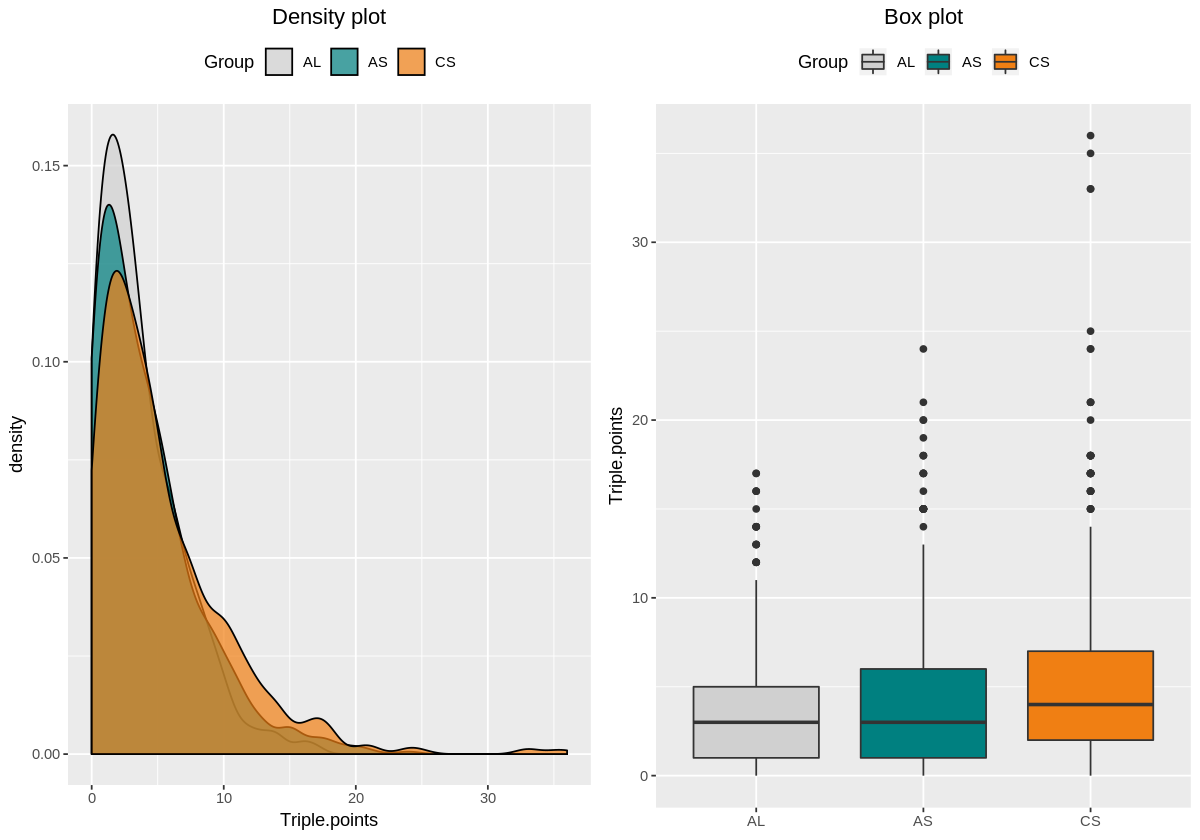

In [29]:
data.description <- mount.description(data,"Triple.points")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Triple.points")
p2 <- custom.box.plot(data, "Triple.points")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var   |  Sd   |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:------:|:-----:|:---:|
|  CS   |  CA1   |  0   |    2    |   4    | 5.679 |  8.00   |  35  | 29.156 | 5.400 | 240 |
|  CS   |  CA3   |  0   |    2    |   4    | 5.125 |  7.25   |  24  | 18.043 | 4.248 | 240 |
|  CS   |   GD   |  0   |    2    |   4    | 5.054 |  7.00   |  36  | 26.796 | 5.177 | 240 |
|  AS   |  CA1   |  0   |    1    |   3    | 4.458 |  6.00   |  24  | 19.002 | 4.359 | 240 |
|  AS   |  CA3   |  0   |    1    |   3    | 4.175 |  6.00   |  18  | 14.438 | 3.800 | 240 |
|  AS   |   GD   |  0   |    1    |   3    | 3.950 |  6.00   |  20  | 12.826 | 3.581 | 240 |
|  AL   |  CA1   |  0   |    2    |   4    | 4.692 |  7.00   |  17  | 13.168 | 3.629 | 240 |
|  AL   |  CA3   |  0   |    1    |   2    | 3.050 |  4.00   |  14  | 8.090  | 2.844 | 240 |
|  AL   |   GD   |  0   |    1    |   3    | 3.421 |  5.00   |  17  

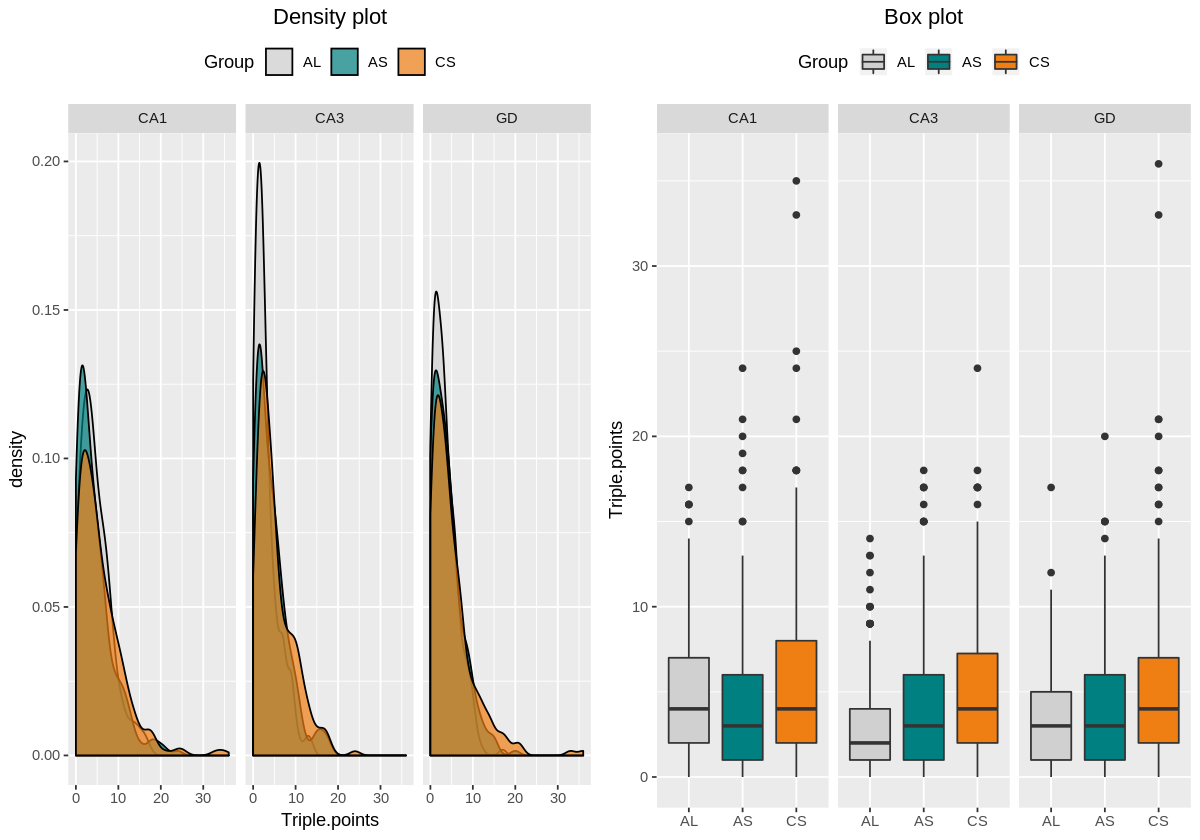

In [30]:
data.description <- mount.description(data, "Triple.points", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Triple.points", region = TRUE)
p2 <- custom.box.plot(data, "Triple.points", region = TRUE)

multiplot(p1,p2,cols = 2)

### Quadruple Points
#### Hippocampus



| Grupo | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var  |  Sd   |  N  |
|:-----:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:-----:|:-----:|:---:|
|  CS   |  0   |    0    |   0    | 0.636 |    1    |  8   | 1.038 | 1.019 | 720 |
|  AS   |  0   |    0    |   0    | 0.525 |    1    |  6   | 0.742 | 0.861 | 720 |
|  AL   |  0   |    0    |   0    | 0.461 |    1    |  5   | 0.613 | 0.783 | 720 |

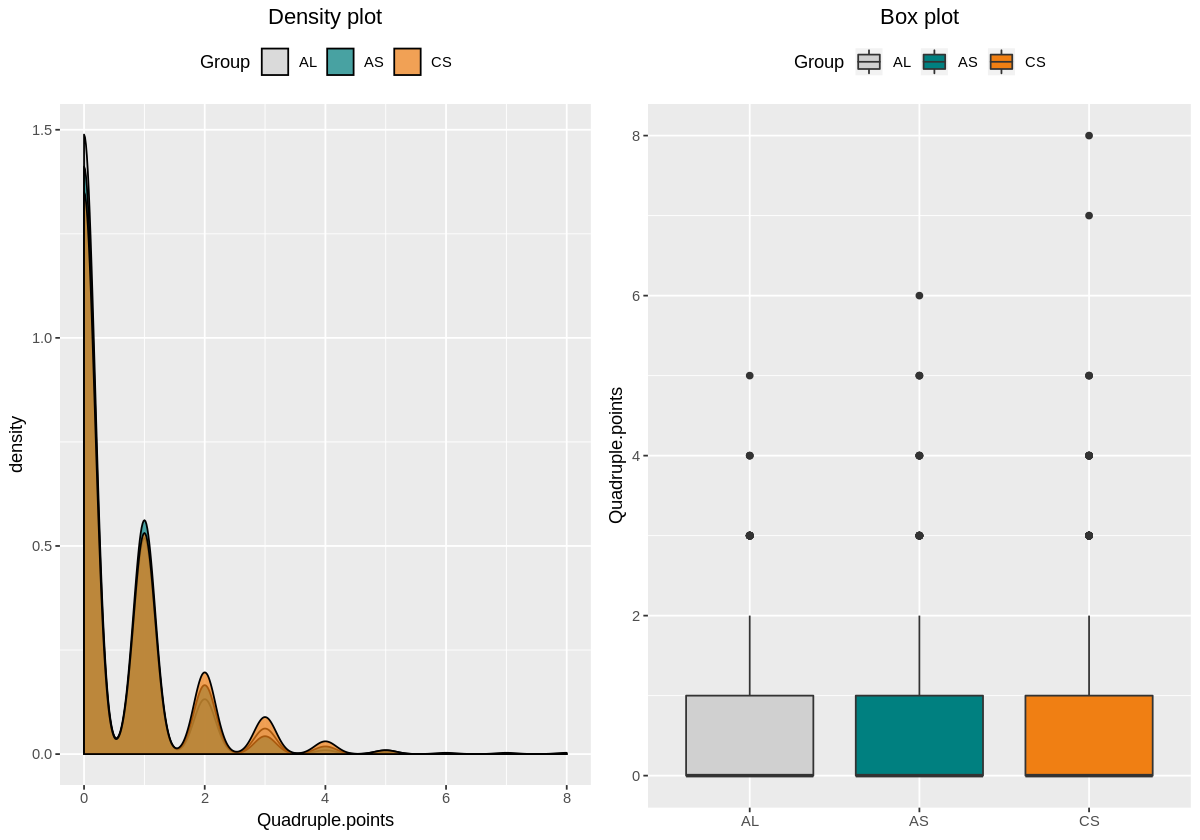

In [31]:
data.description <- mount.description(data,"Quadruple.points")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Quadruple.points")
p2 <- custom.box.plot(data, "Quadruple.points")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var  |  Sd   |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:-----:|:-----:|:---:|
|  CS   |  CA1   |  0   |    0    |   0    | 0.688 |    1    |  5   | 1.044 | 1.022 | 240 |
|  CS   |  CA3   |  0   |    0    |   0    | 0.542 |    1    |  7   | 0.810 | 0.900 | 240 |
|  CS   |   GD   |  0   |    0    |   0    | 0.679 |    1    |  8   | 1.256 | 1.121 | 240 |
|  AS   |  CA1   |  0   |    0    |   0    | 0.617 |    1    |  6   | 1.007 | 1.004 | 240 |
|  AS   |  CA3   |  0   |    0    |   0    | 0.529 |    1    |  4   | 0.685 | 0.828 | 240 |
|  AS   |   GD   |  0   |    0    |   0    | 0.429 |    1    |  5   | 0.522 | 0.723 | 240 |
|  AL   |  CA1   |  0   |    0    |   0    | 0.588 |    1    |  5   | 0.913 | 0.955 | 240 |
|  AL   |  CA3   |  0   |    0    |   0    | 0.371 |    1    |  3   | 0.418 | 0.647 | 240 |
|  AL   |   GD   |  0   |    0    |   0    | 0.425 |    1    |  4   | 0.488 | 

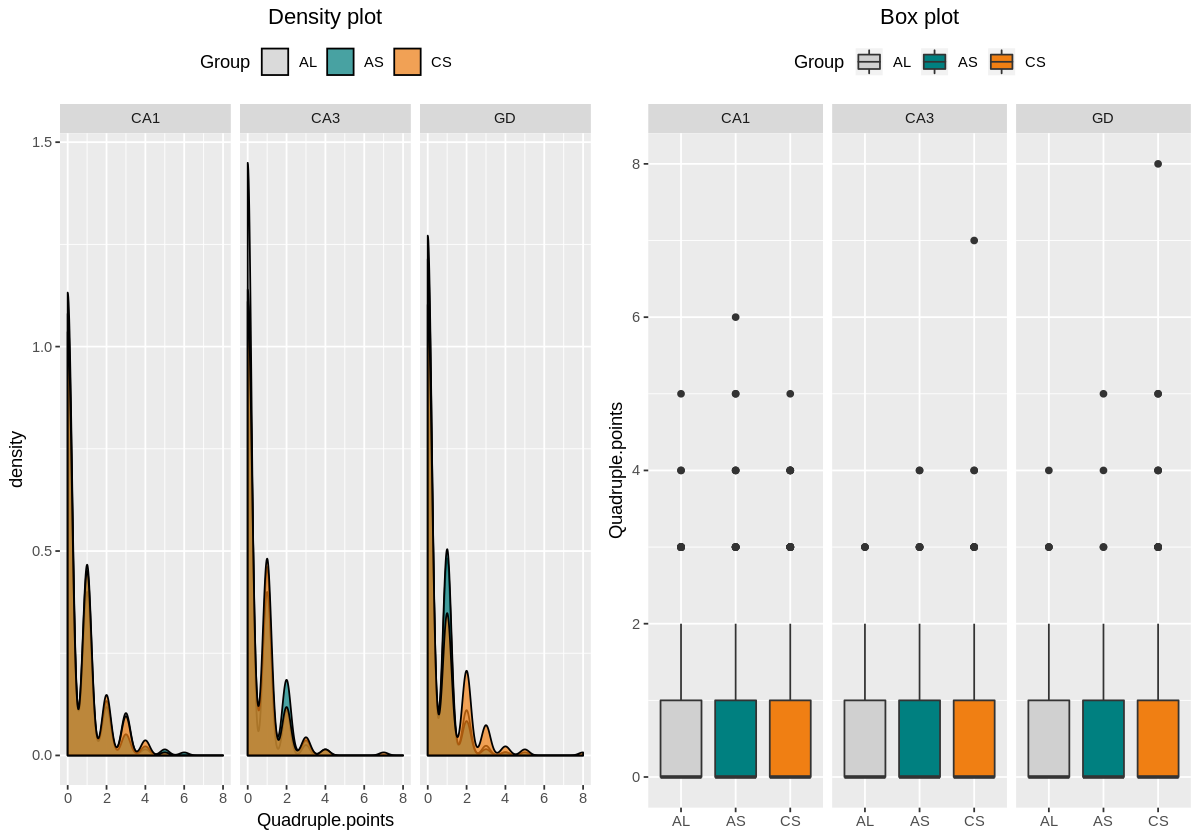

In [32]:
data.description <- mount.description(data, "Quadruple.points", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Quadruple.points", region = TRUE)
p2 <- custom.box.plot(data, "Quadruple.points", region = TRUE)

multiplot(p1,p2,cols = 2)

### End points
#### Hippocampus



| Grupo | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var   |  Sd   |  N  |
|:-----:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:------:|:-----:|:---:|
|  CS   |  1   |    4    |   6    | 7.406 |    9    |  29  | 22.364 | 4.729 | 720 |
|  AS   |  1   |    3    |   6    | 6.497 |    8    |  25  | 16.242 | 4.030 | 720 |
|  AL   |  0   |    3    |   5    | 5.900 |    8    |  19  | 10.443 | 3.232 | 720 |

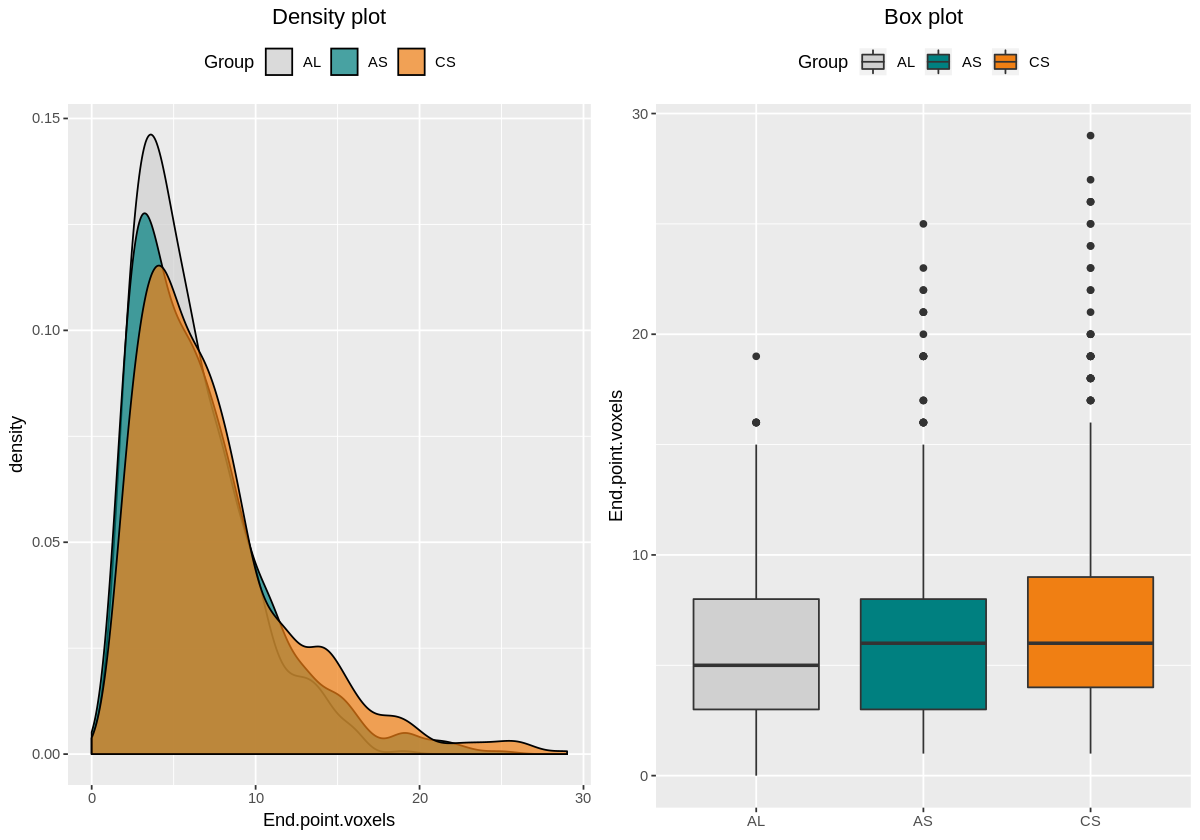

In [33]:
data.description <- mount.description(data,"End.point.voxels")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "End.point.voxels")
p2 <- custom.box.plot(data, "End.point.voxels")

multiplot(p1,p2,cols = 2)


#### Regions



| Grupo | Região | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var   |  Sd   |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:------:|:-----:|:---:|
|  CS   |  CA1   |  1   |  4.00   |  6.5   | 7.800 |   10    |  27  | 27.056 | 5.202 | 240 |
|  CS   |  CA3   |  1   |  4.00   |  6.0   | 7.367 |    9    |  25  | 19.396 | 4.404 | 240 |
|  CS   |   GD   |  2   |  4.00   |  6.0   | 7.050 |    9    |  29  | 20.541 | 4.532 | 240 |
|  AS   |  CA1   |  1   |  3.75   |  6.0   | 6.838 |    9    |  25  | 19.609 | 4.428 | 240 |
|  AS   |  CA3   |  2   |  3.00   |  6.0   | 6.529 |    9    |  21  | 15.129 | 3.890 | 240 |
|  AS   |   GD   |  2   |  3.00   |  5.0   | 6.125 |    8    |  22  | 13.867 | 3.724 | 240 |
|  AL   |  CA1   |  2   |  4.00   |  6.0   | 6.787 |    9    |  19  | 12.846 | 3.584 | 240 |
|  AL   |  CA3   |  1   |  3.00   |  4.0   | 5.308 |    7    |  16  | 9.110  | 3.018 | 240 |
|  AL   |   GD   |  0   |  3.00   |  5.0   | 5.604 |    7    |  14  

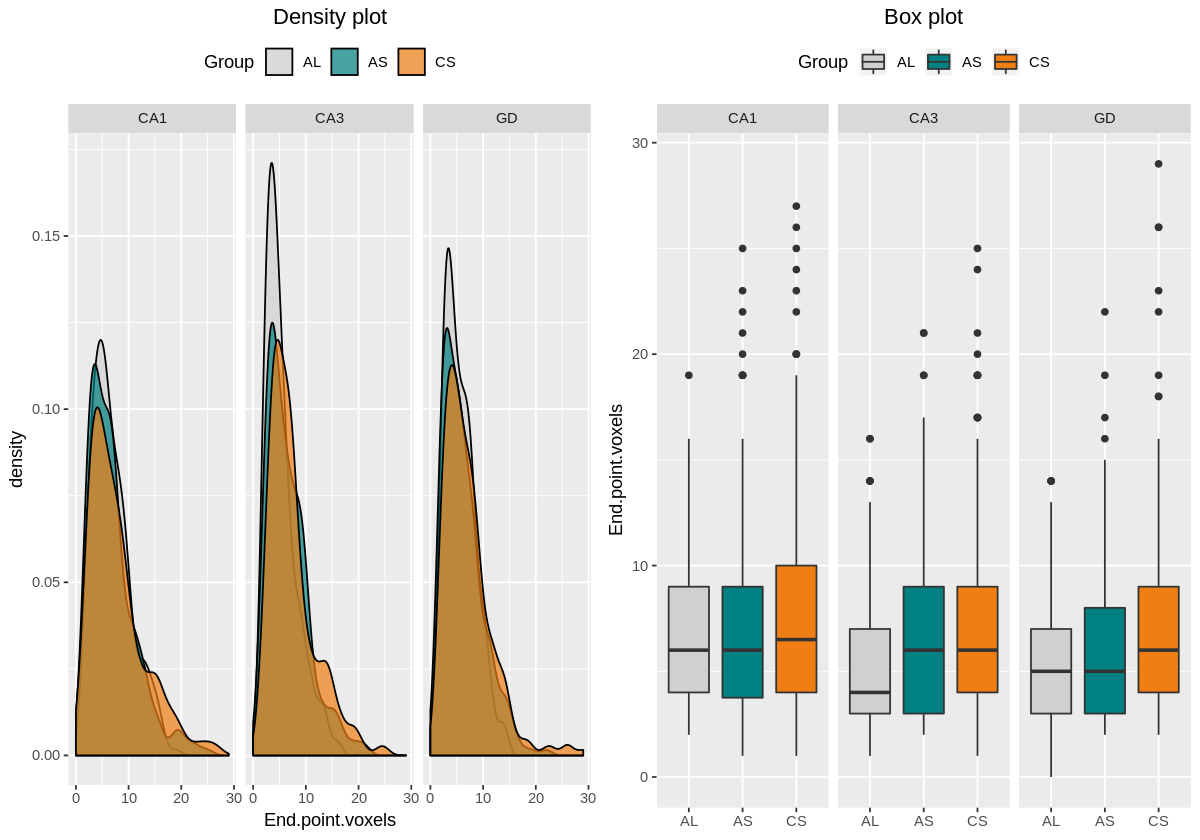

In [34]:
data.description <- mount.description(data, "End.point.voxels", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"End.point.voxels", region = TRUE)
p2 <- custom.box.plot(data, "End.point.voxels", region = TRUE)

multiplot(p1,p2,cols = 2)

### Average Branch Length
#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.   |   Var   |   Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:------:|:-------:|:-------:|:-------:|:------:|:---:|
|  CS   | 4.748 | 11.263  | 13.292 | 15.431 | 16.564  | 121.296 | 72.709  | 8.527  | 720 |
|  AS   | 1.414 | 11.064  | 13.254 | 15.775 | 17.035  | 66.698  | 75.828  | 8.708  | 720 |
|  AL   | 2.414 | 10.942  | 13.361 | 16.209 | 17.017  | 100.083 | 101.711 | 10.085 | 720 |

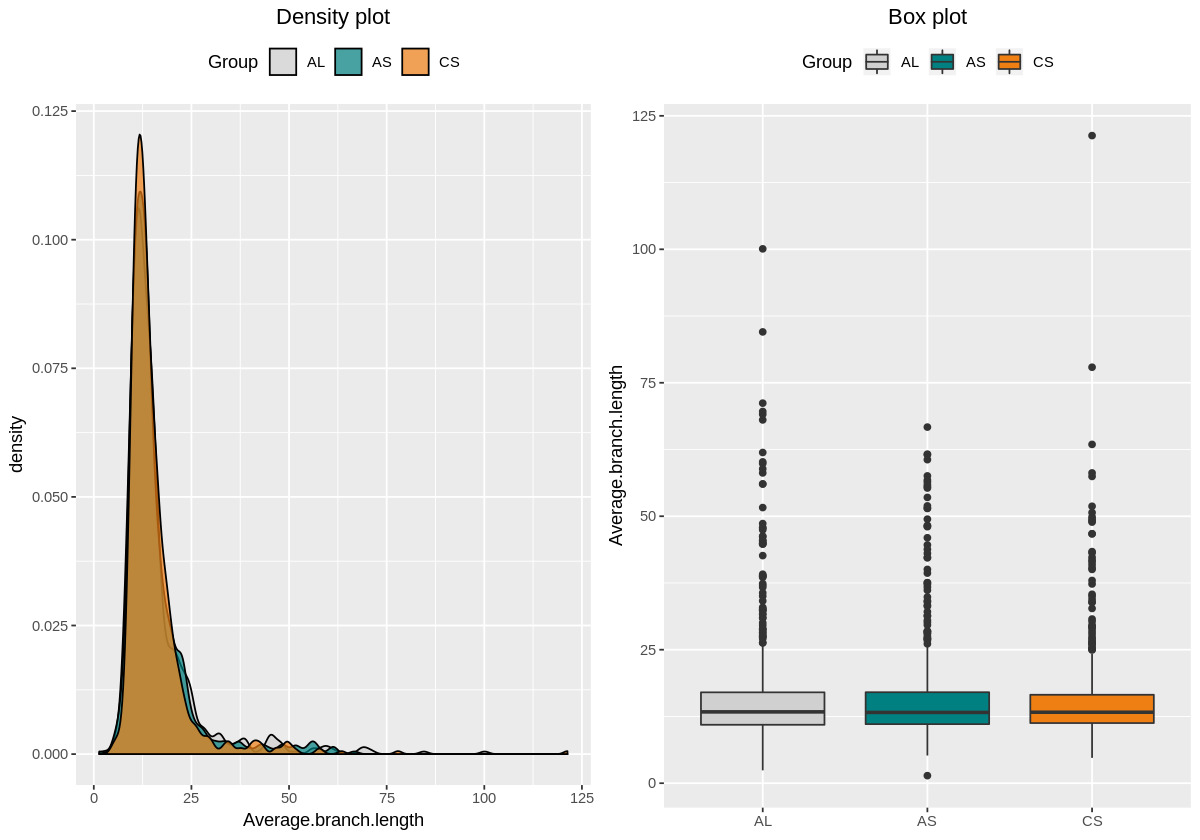

In [35]:
data.description <- mount.description(data,"Average.branch.length")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Average.branch.length")
p2 <- custom.box.plot(data, "Average.branch.length")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.   |   Var   |   Sd   |  N  |
|:-----:|:------:|:-----:|:-------:|:------:|:------:|:-------:|:-------:|:-------:|:------:|:---:|
|  CS   |  CA1   | 6.690 | 10.979  | 13.063 | 16.224 | 17.127  | 121.296 | 123.382 | 11.108 | 240 |
|  CS   |  CA3   | 4.748 | 11.639  | 13.825 | 14.979 | 16.728  | 58.113  | 31.205  | 5.586  | 240 |
|  CS   |   GD   | 5.552 | 10.830  | 12.696 | 15.092 | 16.110  | 63.456  | 63.198  | 7.950  | 240 |
|  AS   |  CA1   | 5.243 | 11.269  | 13.472 | 16.012 | 18.415  | 61.627  | 63.239  | 7.952  | 240 |
|  AS   |  CA3   | 5.414 | 10.868  | 13.195 | 15.628 | 16.941  | 57.556  | 68.720  | 8.290  | 240 |
|  AS   |   GD   | 1.414 | 10.945  | 13.020 | 15.685 | 16.061  | 66.698  | 96.074  | 9.802  | 240 |
|  AL   |  CA1   | 7.427 | 10.867  | 12.553 | 15.768 | 16.064  | 100.083 | 110.316 | 10.503 | 240 |
|  AL   |  CA3   | 2.414 | 11.153  | 14.023 | 17.211 | 17.778  | 84.527  | 117.181 | 10.825 | 240 

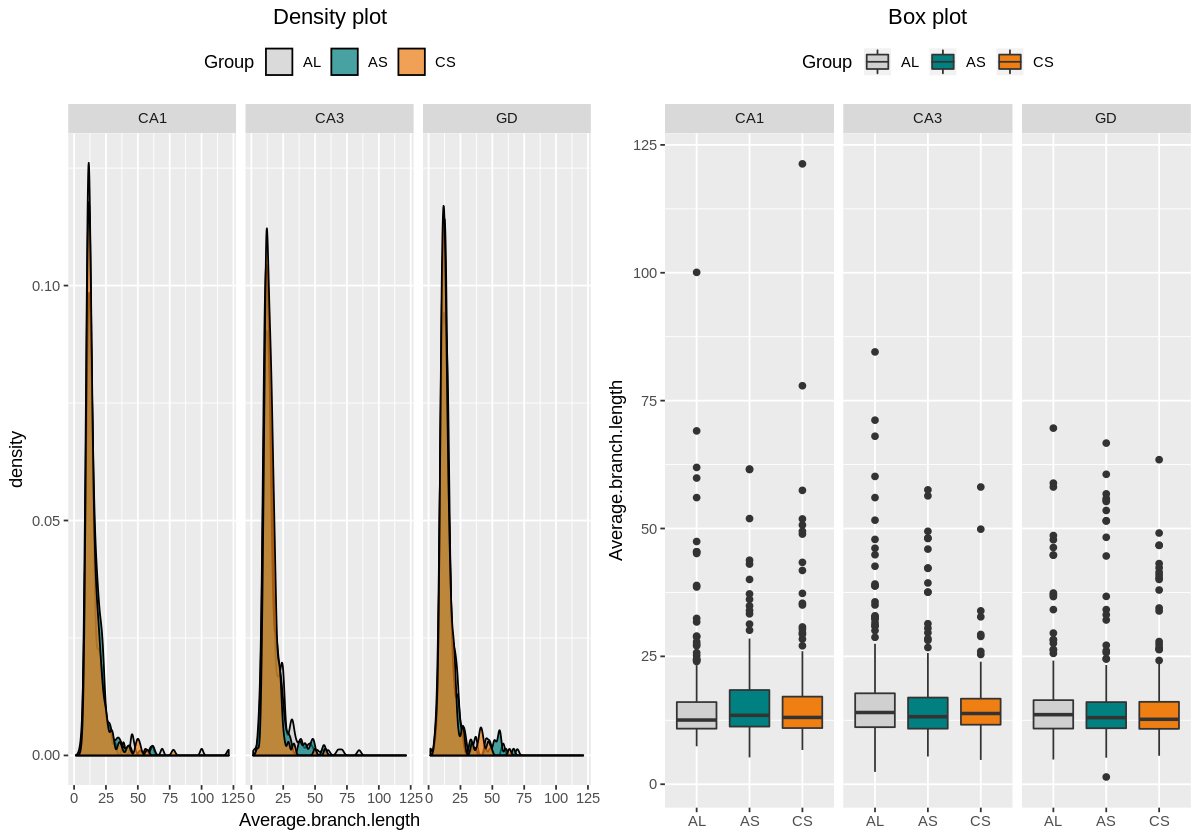

In [36]:
data.description <- mount.description(data, "Average.branch.length", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Average.branch.length", region = TRUE)
p2 <- custom.box.plot(data, "Average.branch.length", region = TRUE)

multiplot(p1,p2,cols = 2)

### Maximum Branch Length
#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.   |   Var   |   Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:------:|:-------:|:-------:|:-------:|:------:|:---:|
|  CS   | 6.828 | 23.314  | 29.703 | 32.473 | 37.556  | 131.468 | 202.092 | 14.216 | 720 |
|  AS   | 1.414 | 22.442  | 28.556 | 30.723 | 36.599  | 103.497 | 151.590 | 12.312 | 720 |
|  AL   | 2.414 | 21.899  | 27.688 | 30.417 | 35.971  | 118.054 | 162.678 | 12.755 | 720 |

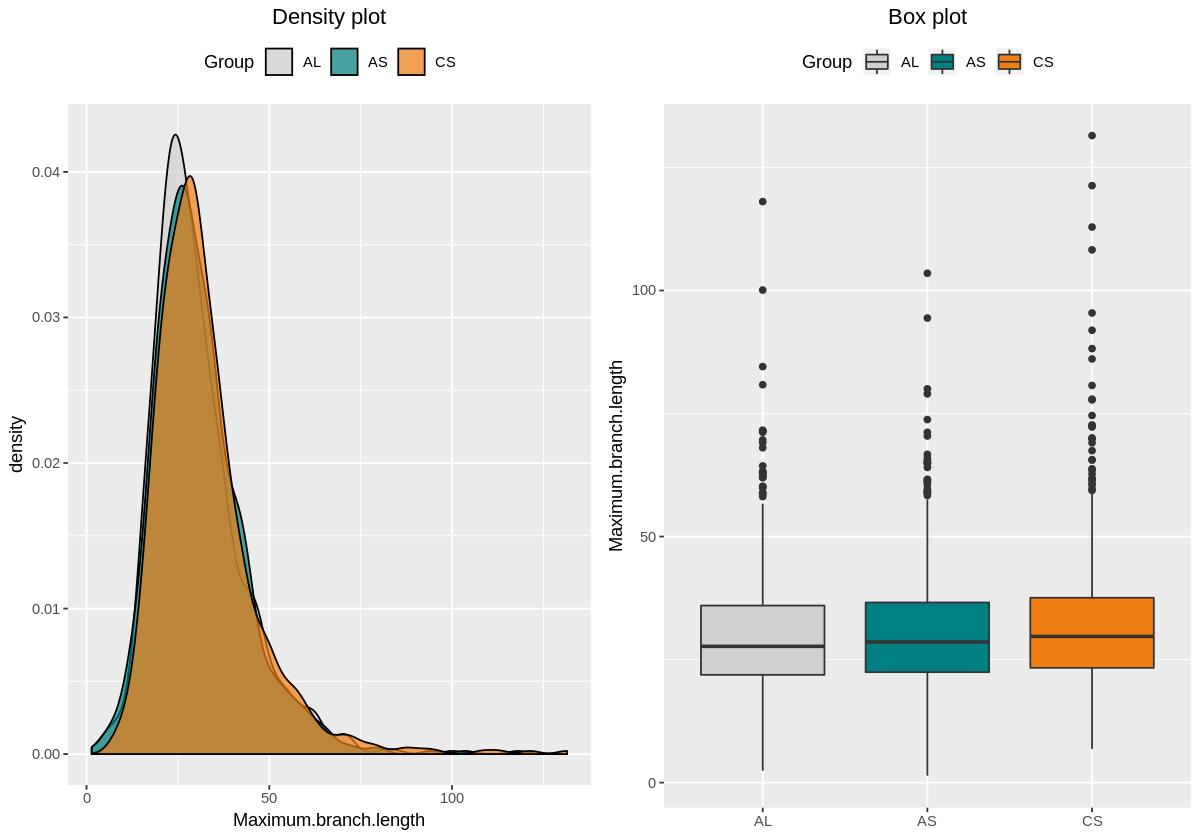

In [37]:
data.description <- mount.description(data,"Maximum.branch.length")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Maximum.branch.length")
p2 <- custom.box.plot(data, "Maximum.branch.length")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região |  Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.   |   Var   |   Sd   |  N  |
|:-----:|:------:|:------:|:-------:|:------:|:------:|:-------:|:-------:|:-------:|:------:|:---:|
|  CS   |  CA1   | 9.243  | 23.728  | 29.971 | 33.976 | 40.014  | 131.468 | 261.505 | 16.171 | 240 |
|  CS   |  CA3   | 9.414  | 24.728  | 30.520 | 32.826 | 38.385  | 86.083  | 138.758 | 11.780 | 240 |
|  CS   |   GD   | 6.828  | 21.399  | 28.521 | 30.617 | 36.728  | 112.882 | 201.850 | 14.207 | 240 |
|  AS   |  CA1   | 5.243  | 23.485  | 30.264 | 31.467 | 37.299  | 94.397  | 138.738 | 11.779 | 240 |
|  AS   |  CA3   | 5.414  | 22.314  | 28.556 | 31.027 | 37.615  | 103.497 | 159.401 | 12.625 | 240 |
|  AS   |   GD   | 1.414  | 21.071  | 27.814 | 29.674 | 35.213  | 80.012  | 156.147 | 12.496 | 240 |
|  AL   |  CA1   | 10.071 | 23.142  | 28.142 | 30.542 | 36.057  | 100.083 | 129.603 | 11.384 | 240 |
|  AL   |  CA3   | 2.414  | 21.728  | 27.264 | 30.605 | 35.739  | 118.054 | 204.906 | 14.

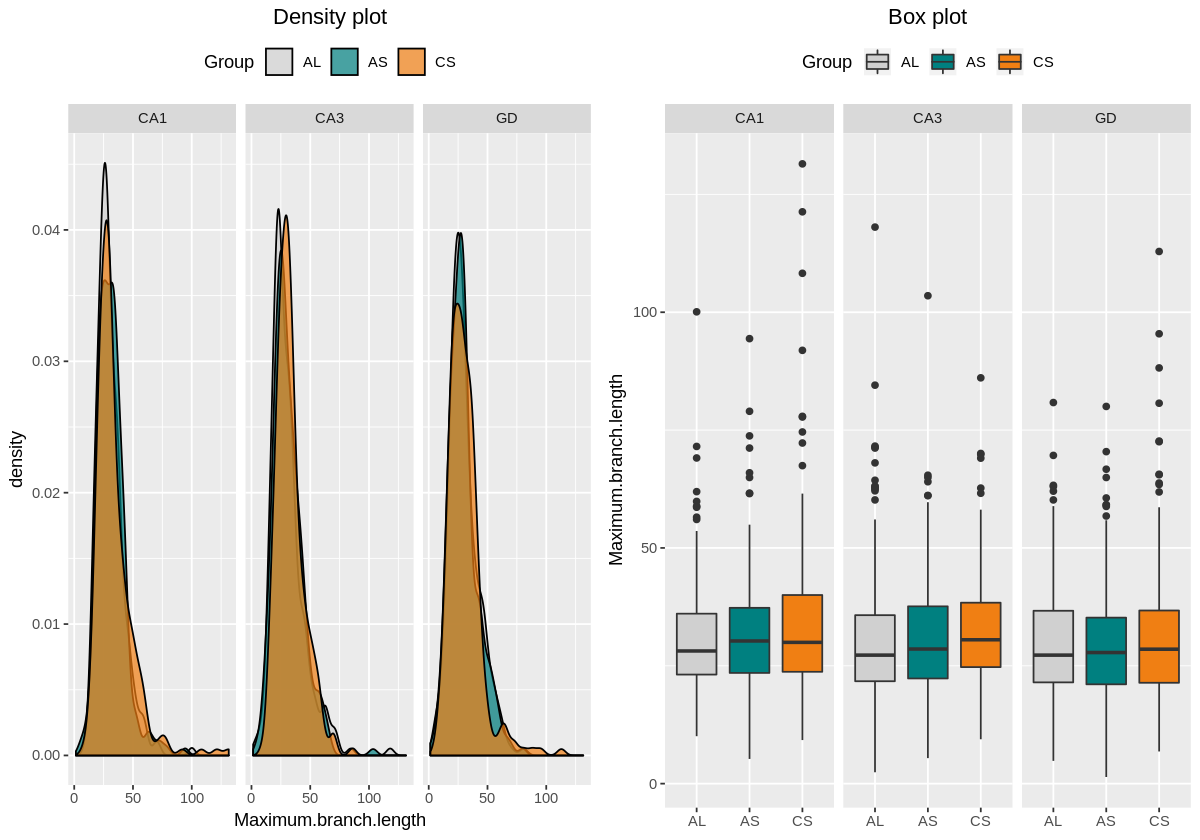

In [38]:
data.description <- mount.description(data, "Maximum.branch.length", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Maximum.branch.length", region = TRUE)
p2 <- custom.box.plot(data, "Maximum.branch.length", region = TRUE)

multiplot(p1,p2,cols = 2)

### D (Fractal Dimension)
#### Hippocampus



| Grupo | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:----:|:-------:|:------:|:-------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   |  1   | 496.75  | 902.5  | 875.254 | 1244.00 | 1688 | 203087.9 | 450.653 | 720 |
|  AS   |  3   | 533.75  | 904.5  | 878.235 | 1261.25 | 1687 | 201257.5 | 448.617 | 720 |
|  AL   |  2   | 470.25  | 809.0  | 813.515 | 1139.25 | 1684 | 175856.2 | 419.352 | 720 |

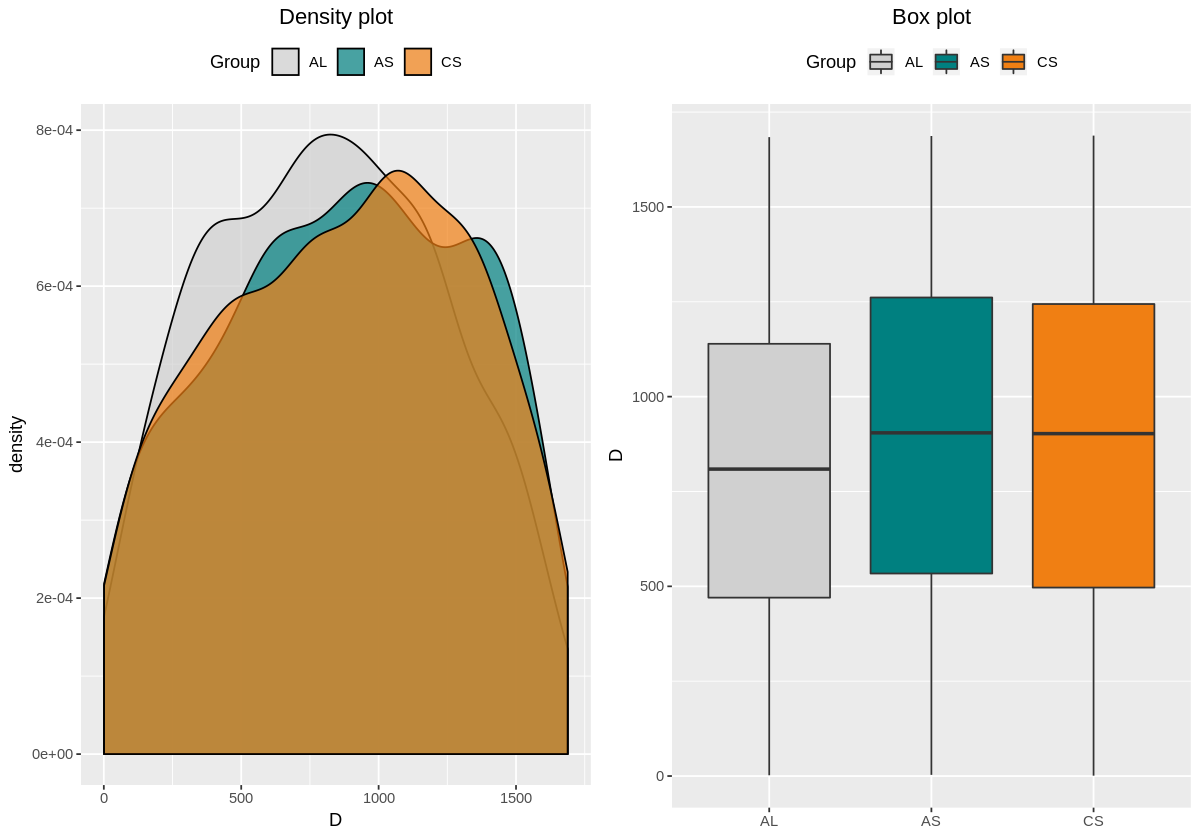

In [39]:
data.description <- mount.description(data,"D")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "D")
p2 <- custom.box.plot(data, "D")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   |  CA1   |  1   | 440.25  | 826.0  | 827.921 | 1217.75 | 1688 | 223893.0 | 473.173 | 240 |
|  CS   |  CA3   |  46  | 494.75  | 832.0  | 847.525 | 1200.00 | 1685 | 178002.7 | 421.904 | 240 |
|  CS   |   GD   |  9   | 622.25  | 1015.5 | 950.317 | 1302.25 | 1682 | 200387.5 | 447.647 | 240 |
|  AS   |  CA1   |  7   | 551.25  | 867.0  | 881.742 | 1255.50 | 1676 | 206546.7 | 454.474 | 240 |
|  AS   |  CA3   |  15  | 471.75  | 874.5  | 851.342 | 1254.25 | 1687 | 211294.3 | 459.668 | 240 |
|  AS   |   GD   |  3   | 545.75  | 939.0  | 901.621 | 1268.00 | 1664 | 186327.7 | 431.657 | 240 |
|  AL   |  CA1   |  36  | 396.25  | 765.0  | 765.538 | 1123.25 | 1678 | 187466.1 | 432.974 | 240 |
|  AL   |  CA3   |  2   | 512.00  | 840.0  | 823.796 | 1164.75 | 1681 | 174486.1 | 417.715 | 240 |
|  AL   

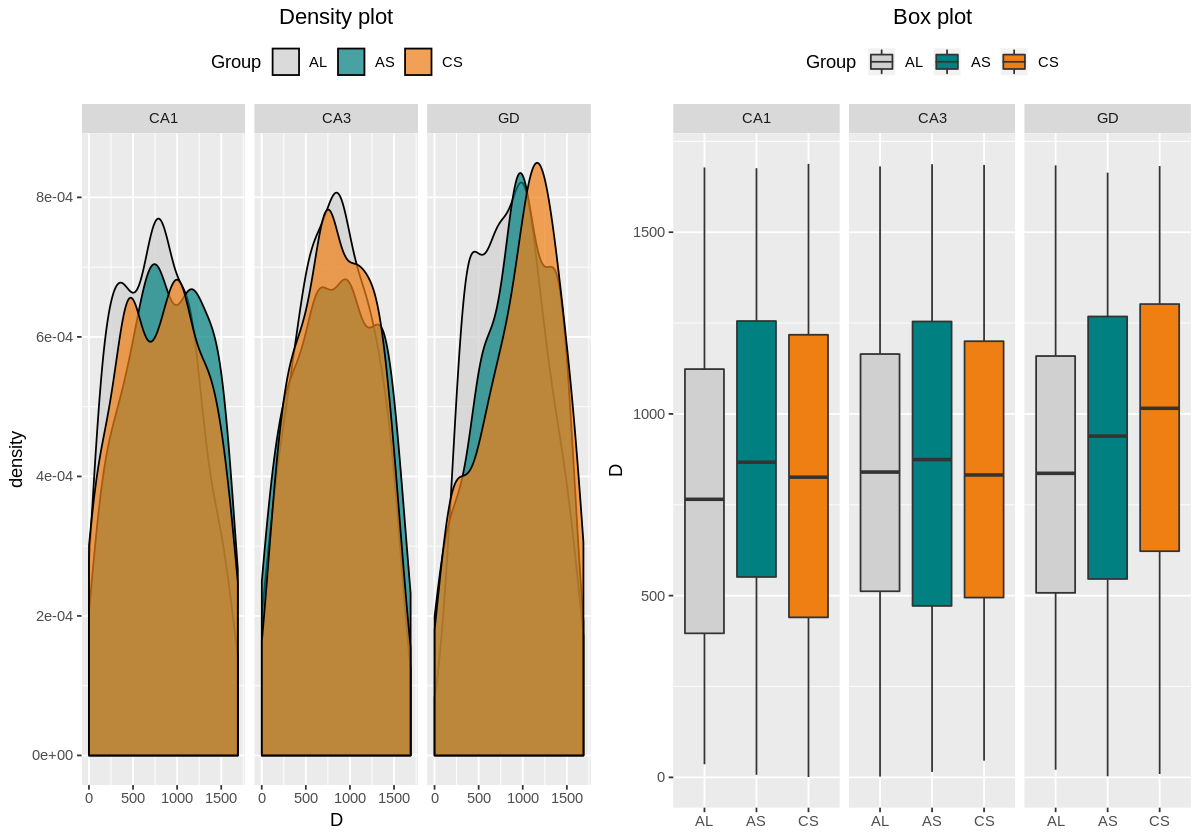

In [40]:
data.description <- mount.description(data, "D", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"D", region = TRUE)
p2 <- custom.box.plot(data, "D", region = TRUE)

multiplot(p1,p2,cols = 2)

### Lacunarity
#### Hippocampus



| Grupo | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:----:|:-------:|:------:|:-------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   |  11  | 530.75  | 937.5  | 915.658 | 1282.00 | 1793 | 226457.6 | 475.876 | 720 |
|  AS   |  4   | 453.25  | 893.5  | 897.692 | 1335.75 | 1799 | 255037.4 | 505.012 | 720 |
|  AL   |  2   | 500.50  | 900.5  | 881.487 | 1252.50 | 1794 | 216290.0 | 465.070 | 720 |

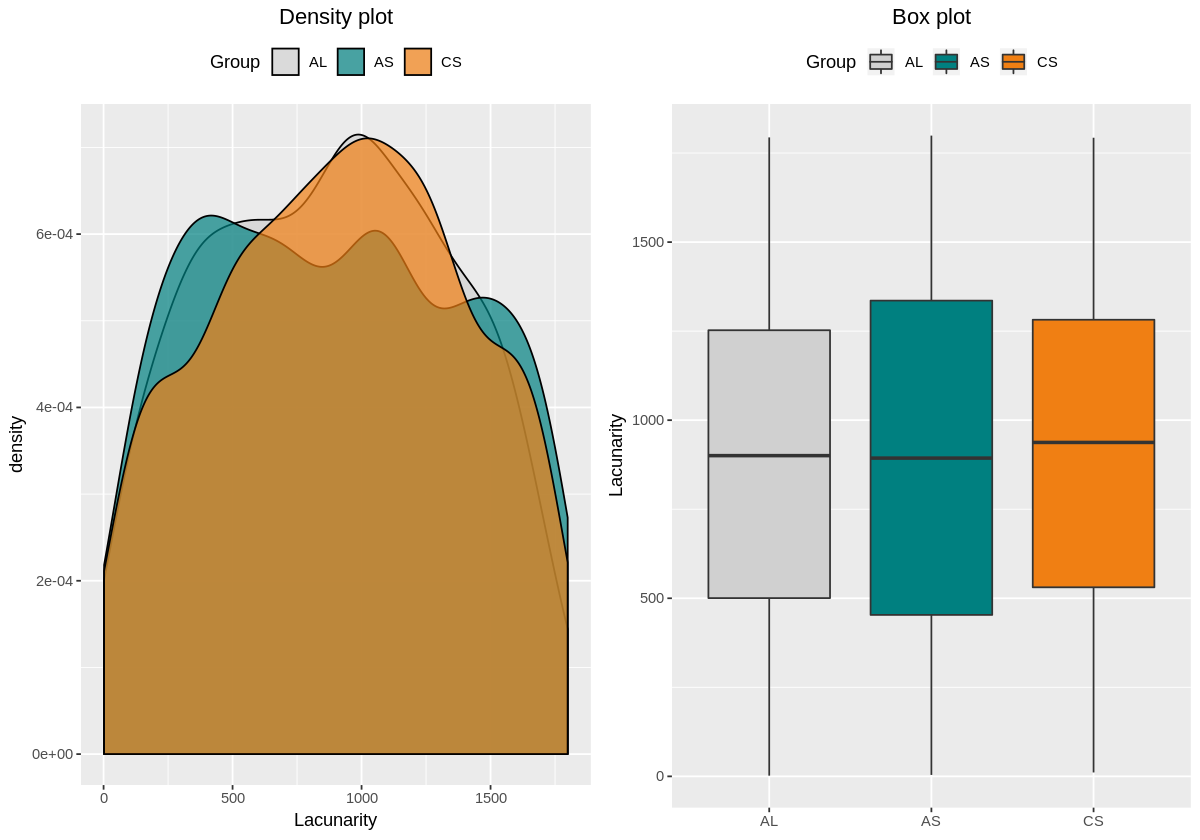

In [41]:
data.description <- mount.description(data,"Lacunarity")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Lacunarity")
p2 <- custom.box.plot(data, "Lacunarity")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   |  CA1   |  11  | 588.00  | 967.0  | 939.396 | 1285.75 | 1786 | 217727.5 | 466.613 | 240 |
|  CS   |  CA3   |  38  | 590.00  | 998.0  | 942.638 | 1275.75 | 1793 | 209765.2 | 458.001 | 240 |
|  CS   |   GD   |  20  | 489.25  | 837.5  | 864.942 | 1280.00 | 1790 | 249895.7 | 499.896 | 240 |
|  AS   |  CA1   |  4   | 524.00  | 920.0  | 942.192 | 1386.25 | 1799 | 260560.7 | 510.451 | 240 |
|  AS   |  CA3   |  12  | 513.50  | 889.5  | 912.962 | 1342.25 | 1791 | 253475.2 | 503.463 | 240 |
|  AS   |   GD   |  43  | 377.50  | 849.5  | 837.921 | 1192.25 | 1797 | 247400.1 | 497.393 | 240 |
|  AL   |  CA1   |  51  | 615.00  | 1014.0 | 986.354 | 1361.25 | 1794 | 210640.2 | 458.956 | 240 |
|  AL   |  CA3   |  3   | 436.75  | 764.0  | 806.208 | 1153.00 | 1764 | 209330.0 | 457.526 | 240 |
|  AL   

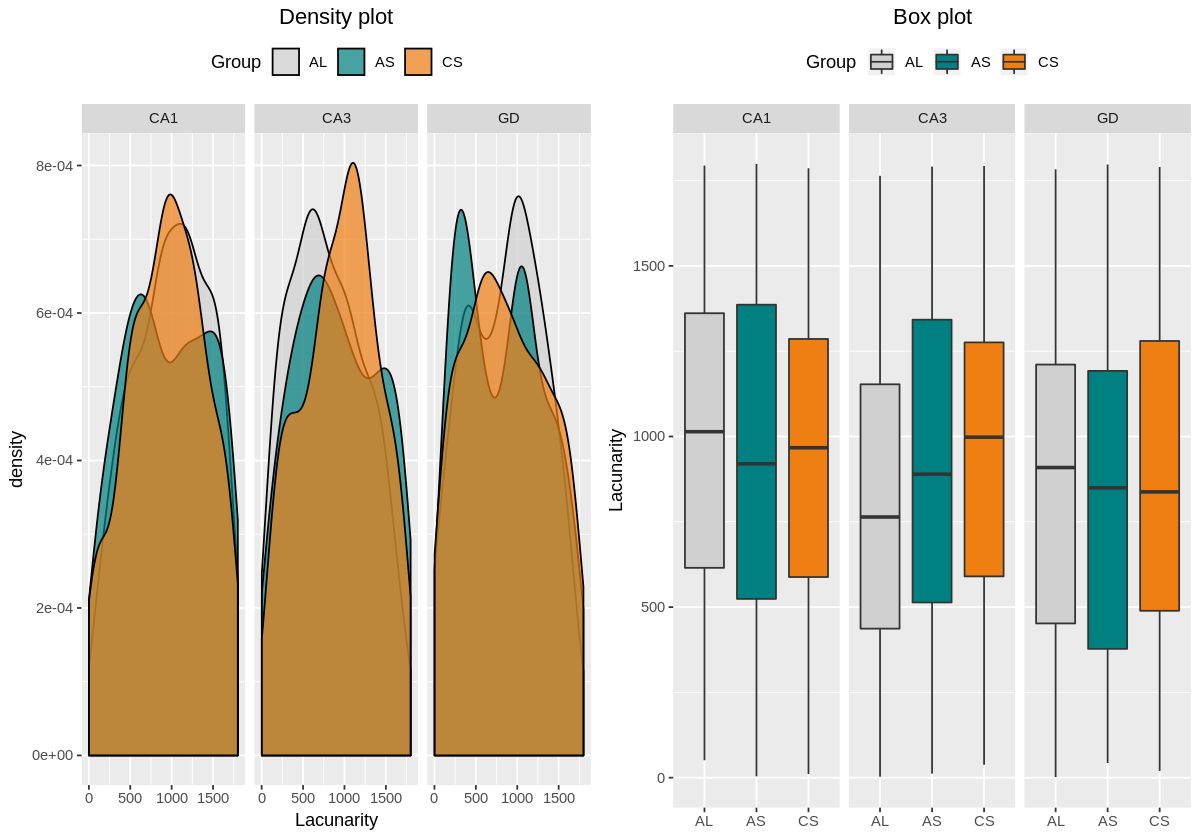

In [42]:
data.description <- mount.description(data, "Lacunarity", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Lacunarity", region = TRUE)
p2 <- custom.box.plot(data, "Lacunarity", region = TRUE)

multiplot(p1,p2,cols = 2)

## Observations

Here I can describe some points to take note off

- variance variablitiy by experimental group (CS2!!)

- Number of cells outside hipocampos in each group (impact on CS2)